In [8]:
# Fix white crops and apply realistic drone viewing angles
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json
import os
from pathlib import Path
from typing import List, Dict, Tuple, Optional
import random

class RealisticDroneExtractor:
    """
    Fix TIF loading issues and create realistic drone perspective crops
    """
    
    def __init__(self, tif_path: str = "sentinel2_ukraine_10km.TIF"):
        self.tif_path = tif_path
        self.image = None
        self.image_info = {}
        
        print(f"🔧 Fixing TIF loading and creating realistic drone perspectives")
        print(f"   Input: {tif_path}")
        
        self.load_tif_properly()
    
    def load_tif_properly(self):
        """Properly load TIF with correct pixel value handling"""
        
        if not os.path.exists(self.tif_path):
            print(f"❌ File not found: {self.tif_path}")
            return
        
        print(f"\n🔍 FIXING TIF LOADING...")
        
        try:
            # Method 1: Try with different OpenCV flags
            methods = [
                ("OpenCV UNCHANGED", cv2.IMREAD_UNCHANGED),
                ("OpenCV COLOR", cv2.IMREAD_COLOR),
                ("OpenCV ANYDEPTH", cv2.IMREAD_ANYDEPTH | cv2.IMREAD_COLOR),
                ("PIL", None)
            ]
            
            for method_name, cv_flag in methods:
                print(f"   Trying {method_name}...")
                
                try:
                    if cv_flag is not None:
                        img = cv2.imread(self.tif_path, cv_flag)
                    else:
                        # PIL method
                        pil_img = Image.open(self.tif_path)
                        img = np.array(pil_img)
                    
                    if img is not None:
                        print(f"      Shape: {img.shape}, dtype: {img.dtype}")
                        print(f"      Value range: {img.min()} - {img.max()}")
                        
                        # Check if image is not all white/black
                        unique_values = len(np.unique(img.flatten()[:1000]))  # Sample first 1000 pixels
                        print(f"      Unique values (sample): {unique_values}")
                        
                        if unique_values > 10:  # Should have variety in satellite imagery
                            self.image = img
                            print(f"   ✅ Successfully loaded with {method_name}")
                            break
                        else:
                            print(f"      ⚠️ Image appears uniform (all white/black)")
                    
                except Exception as e:
                    print(f"      ❌ {method_name} error: {e}")
            
            if self.image is not None:
                self.normalize_image()
            else:
                print("❌ Could not load TIF properly with any method")
                
        except Exception as e:
            print(f"❌ Error in TIF loading: {e}")
    
    def normalize_image(self):
        """Normalize image for proper display and processing"""
        
        print(f"\n📊 NORMALIZING IMAGE...")
        
        original_shape = self.image.shape
        original_dtype = self.image.dtype
        original_range = [self.image.min(), self.image.max()]
        
        # Handle different data types
        if self.image.dtype == np.uint16:
            print("   Converting from 16-bit to 8-bit...")
            # Normalize 16-bit to 8-bit
            self.image = (self.image.astype(np.float32) / 65535.0 * 255).astype(np.uint8)
        
        elif self.image.dtype in [np.float32, np.float64]:
            print("   Converting from float to 8-bit...")
            # Normalize float to 8-bit
            img_min, img_max = self.image.min(), self.image.max()
            if img_max > img_min:
                self.image = ((self.image - img_min) / (img_max - img_min) * 255).astype(np.uint8)
            else:
                self.image = np.zeros_like(self.image, dtype=np.uint8)
        
        elif self.image.dtype == np.uint8:
            print("   Already 8-bit, checking range...")
            # Check if values are in unexpected range
            if self.image.max() < 50:  # Very dark image
                print("   Enhancing contrast...")
                self.image = cv2.equalizeHist(self.image) if len(self.image.shape) == 2 else self.image
        
        # Handle single band vs multi-band
        if len(self.image.shape) == 2:
            print("   Converting grayscale to RGB...")
            self.image = cv2.cvtColor(self.image, cv2.COLOR_GRAY2RGB)
        elif self.image.shape[2] > 3:
            print(f"   Using first 3 bands from {self.image.shape[2]} bands...")
            self.image = self.image[:, :, :3]
        
        print(f"   ✅ Normalized: {original_shape} {original_dtype} → {self.image.shape} {self.image.dtype}")
        print(f"   Value range: {original_range} → [{self.image.min()}, {self.image.max()}]")
        
        # Store info
        self.image_info = {
            'original_shape': original_shape,
            'original_dtype': str(original_dtype),
            'original_range': original_range,
            'normalized_shape': self.image.shape,
            'normalized_dtype': str(self.image.dtype),
            'normalized_range': [int(self.image.min()), int(self.image.max())]
        }
    
    def display_fixed_image(self):
        """Display the properly loaded image"""
        
        if self.image is None:
            print("❌ No image loaded")
            return
        
        print(f"\n🖼️ DISPLAYING FIXED IMAGE...")
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Fixed Ukraine Satellite Image', fontsize=16)
        
        # Full image
        axes[0, 0].imshow(self.image)
        axes[0, 0].set_title(f'Full Image\n{self.image.shape[1]}×{self.image.shape[0]} pixels')
        axes[0, 0].axis('off')
        
        # Histogram
        colors = ['red', 'green', 'blue']
        for i, color in enumerate(colors):
            if i < self.image.shape[2]:
                axes[0, 1].hist(self.image[:, :, i].flatten(), bins=50, alpha=0.5, 
                               color=color, label=f'{color.title()} channel')
        
        axes[0, 1].set_title('Pixel Distribution (Should show variety)')
        axes[0, 1].set_xlabel('Pixel Value')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].legend()
        
        # Center crop
        h, w = self.image.shape[:2]
        center_crop = self.image[h//4:3*h//4, w//4:3*w//4]
        axes[1, 0].imshow(center_crop)
        axes[1, 0].set_title('Center Region\n(Should show terrain features)')
        axes[1, 0].axis('off')
        
        # Info
        info_text = f"""
LOADING RESULTS:
✅ Original: {self.image_info['original_shape']} {self.image_info['original_dtype']}
✅ Range: {self.image_info['original_range']}
✅ Normalized: {self.image_info['normalized_shape']} {self.image_info['normalized_dtype']}
✅ New range: {self.image_info['normalized_range']}

FILE INFO:
• Size: {os.path.getsize(self.tif_path) / 1024 / 1024:.1f} MB
• Location: Ukraine 50.2957°N, 36.6619°E
• Coverage: ~10km × 10km
        """
        
        axes[1, 1].text(0.05, 0.95, info_text.strip(), transform=axes[1, 1].transAxes,
                        fontsize=10, verticalalignment='top', fontfamily='monospace',
                        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
        axes[1, 1].set_title('Loading Information')
        axes[1, 1].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    def create_realistic_drone_perspectives(self, num_crops: int = 30) -> List[Dict]:
        """
        Create realistic drone perspectives with 60° viewing angles
        """
        
        if self.image is None:
            print("❌ No image loaded")
            return []
        
        print(f"\n📐 CREATING REALISTIC DRONE PERSPECTIVES")
        print(f"   Viewing angle: ~60° from vertical (oblique)")
        print(f"   Number of crops: {num_crops}")
        
        output_dir = Path("realistic_drone_crops")
        output_dir.mkdir(exist_ok=True)
        
        h, w = self.image.shape[:2]
        crops_data = []
        
        # Different crop sizes for variety
        crop_sizes = [128, 192, 256, 320]
        
        for crop_idx in range(num_crops):
            crop_size = random.choice(crop_sizes)
            margin = crop_size
            
            # Random position (with margin for perspective transform)
            center_x = random.randint(margin, w - margin)
            center_y = random.randint(margin, h - margin)
            
            # Extract base crop
            x1 = center_x - crop_size // 2
            y1 = center_y - crop_size // 2
            x2 = x1 + crop_size
            y2 = y1 + crop_size
            
            base_crop = self.image[y1:y2, x1:x2].copy()
            
            # Apply realistic drone perspective transformation
            drone_crop = self.apply_drone_perspective(base_crop, crop_idx)
            
            if drone_crop is not None:
                # Save crop
                filename = f"drone_realistic_{crop_idx:03d}_{crop_size}px.jpg"
                filepath = output_dir / filename
                cv2.imwrite(str(filepath), cv2.cvtColor(drone_crop, cv2.COLOR_RGB2BGR), 
                           [cv2.IMWRITE_JPEG_QUALITY, 90])
                
                crop_info = {
                    'filename': filename,
                    'crop_index': crop_idx,
                    'crop_size': crop_size,
                    'center_pixel': [center_x, center_y],
                    'viewing_angle_deg': 80,
                    'perspective_type': 'oblique_drone',
                    'transformations': ['perspective_warp', 'lighting', 'atmospheric']
                }
                
                crops_data.append(crop_info)
                
                if crop_idx % 10 == 0:
                    print(f"   Progress: {crop_idx + 1}/{num_crops}")
        
        # Save metadata
        metadata = {
            'total_crops': len(crops_data),
            'viewing_angle_degrees': 60,
            'perspective_type': 'realistic_drone_oblique',
            'source_image': self.tif_path,
            'image_info': self.image_info,
            'crops': crops_data
        }
        
        metadata_file = output_dir / "realistic_drone_metadata.json"
        with open(metadata_file, 'w') as f:
            json.dump(metadata, f, indent=2)
        
        print(f"✅ Created {len(crops_data)} realistic drone perspectives")
        print(f"   Output: {output_dir}")
        print(f"   Metadata: {metadata_file}")
        
        return crops_data
    
    def apply_drone_perspective(self, crop: np.ndarray, seed: int) -> Optional[np.ndarray]:
        """
        Apply realistic 60° drone perspective transformation
        """
        
        random.seed(seed)  # Reproducible transformations
        
        h, w = crop.shape[:2]
        
        # 1. Perspective transformation (simulate 60° viewing angle)
        perspective_crop = self.apply_perspective_warp(crop)
        
        # 2. Lighting changes (different sun angle from drone perspective)
        lit_crop = self.apply_drone_lighting(perspective_crop)
        
        # 3. Atmospheric effects (altitude-dependent)
        atmospheric_crop = self.apply_atmospheric_effects(lit_crop)
        
        # 4. Camera effects (drone camera characteristics)
        final_crop = self.apply_camera_effects(atmospheric_crop)
        
        return final_crop
    
    def apply_perspective_warp(self, crop: np.ndarray) -> np.ndarray:
        """Apply perspective warp to simulate 60° viewing angle"""
        
        h, w = crop.shape[:2]
        
        # Define perspective transformation
        # Simulate looking at ground from 60° angle
        perspective_strength = random.uniform(0.2, 0.4)
        
        # Source points (original corners)
        src_pts = np.float32([
            [0, 0],      # Top-left
            [w, 0],      # Top-right
            [w, h],      # Bottom-right
            [0, h]       # Bottom-left
        ])
        
        # Destination points (perspective-warped)
        # Top becomes narrower (farther), bottom stays wider (closer)
        top_squeeze = int(w * perspective_strength)
        
        dst_pts = np.float32([
            [top_squeeze, 0],                    # Top-left (squeezed)
            [w - top_squeeze, 0],               # Top-right (squeezed)
            [w, h],                             # Bottom-right (unchanged)
            [0, h]                              # Bottom-left (unchanged)
        ])
        
        # Apply perspective transformation
        M = cv2.getPerspectiveTransform(src_pts, dst_pts)
        warped = cv2.warpPerspective(crop, M, (w, h))
        
        return warped
    
    def apply_drone_lighting(self, crop: np.ndarray) -> np.ndarray:
        """Apply lighting changes from drone perspective"""
        
        # Shadows and highlights are different from drone angle
        lighting_factor = random.uniform(0.8, 1.2)
        shadow_strength = random.uniform(0.1, 0.3)
        
        # Convert to HSV for better lighting control
        hsv = cv2.cvtColor(crop, cv2.COLOR_RGB2HSV).astype(np.float32)
        
        # Adjust brightness (V channel)
        hsv[:, :, 2] *= lighting_factor
        
        # Add gradient lighting (top darker, bottom brighter)
        h, w = crop.shape[:2]
        gradient = np.linspace(1 - shadow_strength, 1 + shadow_strength, h)
        gradient = gradient.reshape(-1, 1)
        
        hsv[:, :, 2] *= gradient
        
        # Clamp values
        hsv[:, :, 2] = np.clip(hsv[:, :, 2], 0, 255)
        
        # Convert back to RGB
        lit_crop = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)
        
        return lit_crop
    
    def apply_atmospheric_effects(self, crop: np.ndarray) -> np.ndarray:
        """Apply atmospheric effects from drone altitude"""
        
        # Slight haze/blur from atmospheric distortion
        if random.random() < 0.4:
            blur_kernel = random.choice([3, 5])
            crop = cv2.GaussianBlur(crop, (blur_kernel, blur_kernel), 0)
        
        # Atmospheric scattering (slight blue tint)
        if random.random() < 0.3:
            blue_tint = np.zeros_like(crop)
            blue_tint[:, :, 2] = random.randint(5, 15)  # Add blue
            crop = cv2.addWeighted(crop, 0.9, blue_tint, 0.1, 0)
        
        return crop
    
    def apply_camera_effects(self, crop: np.ndarray) -> np.ndarray:
        """Apply drone camera characteristics"""
        
        # Random rotation (drone orientation)
        angle = random.uniform(-25, 25)
        h, w = crop.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        crop = cv2.warpAffine(crop, M, (w, h))
        
        # Brightness and contrast (camera settings)
        alpha = random.uniform(0.85, 1.15)  # Contrast
        beta = random.randint(-15, 15)      # Brightness
        crop = cv2.convertScaleAbs(crop, alpha=alpha, beta=beta)
        
        # Slight noise (sensor noise)
        if random.random() < 0.5:
            noise = np.random.randint(-8, 8, crop.shape, dtype=np.int16)
            crop = np.clip(crop.astype(np.int16) + noise, 0, 255).astype(np.uint8)
        
        return crop
    
    def visualize_realistic_crops(self, crops_data: List[Dict], num_display: int = 12):
        """Visualize the realistic drone crops"""
        
        if not crops_data:
            print("❌ No crops to visualize")
            return
        
        print(f"🖼️ Visualizing {num_display} realistic drone crops...")
        
        output_dir = Path("realistic_drone_crops")
        sample_crops = crops_data[:num_display]
        
        cols = 4
        rows = (len(sample_crops) + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
        if rows == 1:
            axes = axes.reshape(1, -1)
        
        for i, crop_info in enumerate(sample_crops):
            row = i // cols
            col = i % cols
            
            crop_path = output_dir / crop_info['filename']
            
            if crop_path.exists():
                crop_img = cv2.imread(str(crop_path))
                crop_rgb = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
                
                axes[row, col].imshow(crop_rgb)
                
                title = f"Realistic Drone #{crop_info['crop_index']:03d}\n"
                title += f"{crop_info['crop_size']}×{crop_info['crop_size']}px\n"
                title += f"60° viewing angle"
                
                axes[row, col].set_title(title, fontsize=10)
                axes[row, col].axis('off')
            else:
                axes[row, col].text(0.5, 0.5, 'File not found', ha='center', va='center',
                                   transform=axes[row, col].transAxes)
        
        # Hide empty subplots
        for i in range(len(sample_crops), rows * cols):
            row = i // cols
            col = i % cols
            axes[row, col].axis('off')
        
        plt.tight_layout()
        plt.suptitle('Realistic Drone Perspectives (60° Oblique View)', fontsize=16, y=1.02)
        plt.show()

# Main function
def fix_and_extract_realistic_drones():
    """
    Fix the white crop issue and create realistic drone perspectives
    """
    
    print("🔧" + "="*60 + "🔧")
    print("    FIXING TIF LOADING & CREATING REALISTIC DRONE VIEWS")
    print("🔧" + "="*60 + "🔧")
    
    # Initialize extractor
    extractor = RealisticDroneExtractor("sentinel2_ukraine_10km.TIF")
    
    if extractor.image is not None:
        # Display the properly loaded image
        extractor.display_fixed_image()
        
        # Create realistic drone perspectives
        crops_data = extractor.create_realistic_drone_perspectives(num_crops=30)
        
        # Visualize results
        extractor.visualize_realistic_crops(crops_data, num_display=12)
        
        print(f"\n🎉 SUCCESS!")
        print(f"   ✅ Fixed TIF loading (no more white crops)")
        print(f"   ✅ Created {len(crops_data)} realistic drone perspectives")
        print(f"   ✅ Applied 60° viewing angle transformations")
        print(f"   ✅ Added atmospheric and camera effects")
        print(f"   📁 Output: realistic_drone_crops/")
        
        return extractor, crops_data
    else:
        print("❌ Could not fix TIF loading")
        return None, []

if __name__ == "__main__":
    print("🔧 TIF FIXER & REALISTIC DRONE PERSPECTIVE CREATOR")
    print("="*60)
    print()
    print("🎯 FIXES:")
    print("   • White crop issue (proper TIF pixel value handling)")
    print("   • Unrealistic top-down view → 60° oblique drone angle")
    print("   • Missing atmospheric effects → realistic drone conditions")
    print()
    print("🚀 FEATURES:")
    print("   • Perspective warping (60° viewing angle)")
    print("   • Drone lighting effects")
    print("   • Atmospheric distortion")
    print("   • Camera sensor characteristics")
    print()
    print("📊 RUN:")
    print("   extractor, crops = fix_and_extract_realistic_drones()")
    print()
    print("🎉 Creates truly realistic drone training data!")

🔧 TIF FIXER & REALISTIC DRONE PERSPECTIVE CREATOR

🎯 FIXES:
   • White crop issue (proper TIF pixel value handling)
   • Unrealistic top-down view → 60° oblique drone angle
   • Missing atmospheric effects → realistic drone conditions

🚀 FEATURES:
   • Perspective warping (60° viewing angle)
   • Drone lighting effects
   • Atmospheric distortion
   • Camera sensor characteristics

📊 RUN:
   extractor, crops = fix_and_extract_realistic_drones()

🎉 Creates truly realistic drone training data!


🇺🇦============================================================🇺🇦
    ANALYZING UKRAINE SATELLITE TIF FILE
🇺🇦============================================================🇺🇦
📁 TIF Drone Extractor
   Input file: sentinel2_ukraine_10km.TIF

📊 ANALYZING TIF FILE...
   Trying PIL...
   ❌ PIL failed: cannot identify image file 'sentinel2_ukraine_10km.TIF'
   Trying OpenCV...
   ✅ Loaded with OpenCV

📊 IMAGE ANALYSIS:
   Shape: (975, 866)
   Data type: uint16
   Value range: 0 - 65535
   File size: 5.8 MB
   Estimated resolution: 11.5m per pixel
   Bands: 1 (grayscale)

🖼️ DISPLAYING IMAGE OVERVIEW...


C:\Users\NIKO9\AppData\Local\Temp\ipykernel_26444\1550739169.py:166: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, 1].legend()


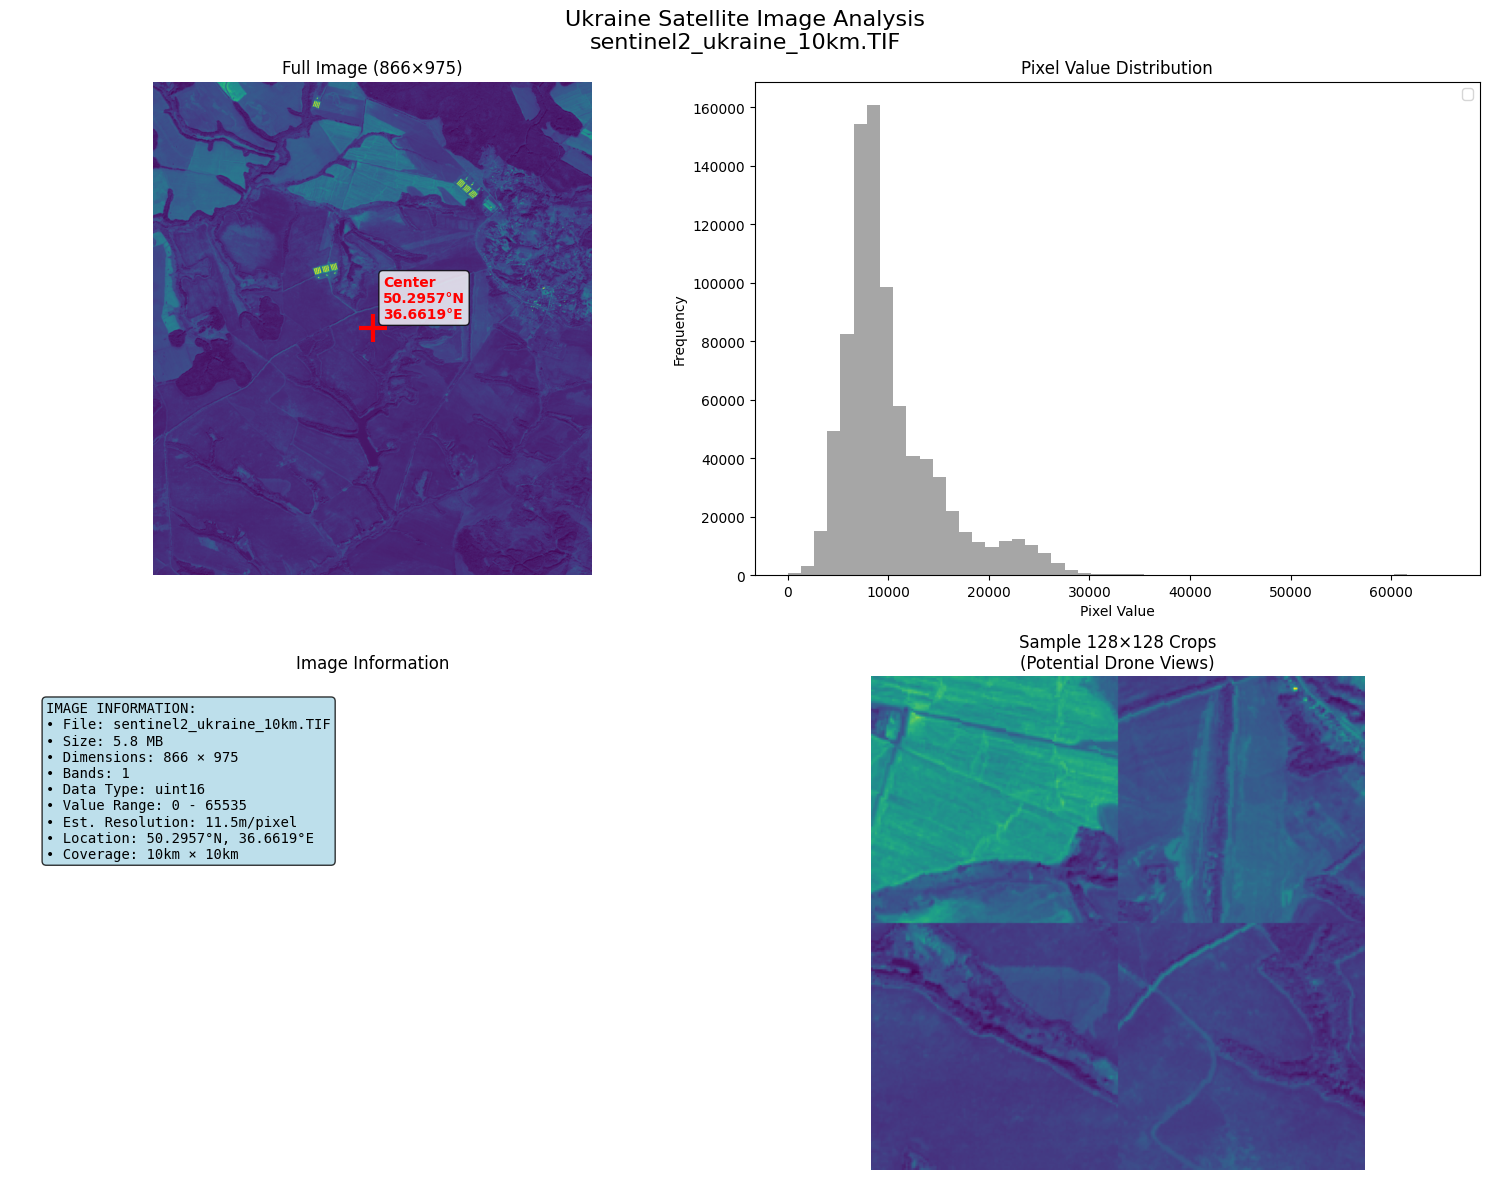


✂️ EXTRACTING DRONE TRAINING CROPS
   Number of crops: 50
   Crop sizes: [128, 256, 512]
   Progress: 0/50


IndexError: tuple index out of range

In [9]:
analyze_ukraine_tif()

In [10]:
# Fix white crops and apply realistic drone viewing angles
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json
import os
from pathlib import Path
from typing import List, Dict, Tuple, Optional
import random

class RealisticDroneExtractor:
    """
    Fix TIF loading issues and create realistic drone perspective crops
    """
    
    def __init__(self, tif_path: str = "sentinel2_ukraine_10km.TIF"):
        self.tif_path = tif_path
        self.image = None
        self.image_info = {}
        
        print(f"🔧 Fixing TIF loading and creating realistic drone perspectives")
        print(f"   Input: {tif_path}")
        
        self.load_tif_properly()
    
    def load_tif_properly(self):
        """Properly load TIF with correct pixel value handling"""
        
        if not os.path.exists(self.tif_path):
            print(f"❌ File not found: {self.tif_path}")
            return
        
        print(f"\n🔍 FIXING TIF LOADING...")
        
        try:
            # Method 1: Try with different OpenCV flags
            methods = [
                ("OpenCV UNCHANGED", cv2.IMREAD_UNCHANGED),
                ("OpenCV COLOR", cv2.IMREAD_COLOR),
                ("OpenCV ANYDEPTH", cv2.IMREAD_ANYDEPTH | cv2.IMREAD_COLOR),
                ("PIL", None)
            ]
            
            for method_name, cv_flag in methods:
                print(f"   Trying {method_name}...")
                
                try:
                    if cv_flag is not None:
                        img = cv2.imread(self.tif_path, cv_flag)
                    else:
                        # PIL method
                        pil_img = Image.open(self.tif_path)
                        img = np.array(pil_img)
                    
                    if img is not None:
                        print(f"      Shape: {img.shape}, dtype: {img.dtype}")
                        print(f"      Value range: {img.min()} - {img.max()}")
                        
                        # Check if image is not all white/black
                        unique_values = len(np.unique(img.flatten()[:1000]))  # Sample first 1000 pixels
                        print(f"      Unique values (sample): {unique_values}")
                        
                        if unique_values > 10:  # Should have variety in satellite imagery
                            self.image = img
                            print(f"   ✅ Successfully loaded with {method_name}")
                            break
                        else:
                            print(f"      ⚠️ Image appears uniform (all white/black)")
                    
                except Exception as e:
                    print(f"      ❌ {method_name} error: {e}")
            
            if self.image is not None:
                self.normalize_image()
            else:
                print("❌ Could not load TIF properly with any method")
                
        except Exception as e:
            print(f"❌ Error in TIF loading: {e}")
    
    def normalize_image(self):
        """Normalize image for proper display and processing"""
        
        print(f"\n📊 NORMALIZING IMAGE...")
        
        original_shape = self.image.shape
        original_dtype = self.image.dtype
        original_range = [self.image.min(), self.image.max()]
        
        # Handle different data types
        if self.image.dtype == np.uint16:
            print("   Converting from 16-bit to 8-bit...")
            # Normalize 16-bit to 8-bit
            self.image = (self.image.astype(np.float32) / 65535.0 * 255).astype(np.uint8)
        
        elif self.image.dtype in [np.float32, np.float64]:
            print("   Converting from float to 8-bit...")
            # Normalize float to 8-bit
            img_min, img_max = self.image.min(), self.image.max()
            if img_max > img_min:
                self.image = ((self.image - img_min) / (img_max - img_min) * 255).astype(np.uint8)
            else:
                self.image = np.zeros_like(self.image, dtype=np.uint8)
        
        elif self.image.dtype == np.uint8:
            print("   Already 8-bit, checking range...")
            # Check if values are in unexpected range
            if self.image.max() < 50:  # Very dark image
                print("   Enhancing contrast...")
                if len(self.image.shape) == 2:
                    self.image = cv2.equalizeHist(self.image)
        
        # FIXED: Handle single band vs multi-band properly
        if len(self.image.shape) == 2:
            print("   Converting grayscale to RGB...")
            self.image = cv2.cvtColor(self.image, cv2.COLOR_GRAY2RGB)
        elif len(self.image.shape) == 3:
            if self.image.shape[2] == 1:
                print("   Converting single channel to RGB...")
                self.image = cv2.cvtColor(self.image, cv2.COLOR_GRAY2RGB)
            elif self.image.shape[2] > 3:
                print(f"   Using first 3 bands from {self.image.shape[2]} bands...")
                self.image = self.image[:, :, :3]
            elif self.image.shape[2] == 4:  # RGBA
                print("   Converting RGBA to RGB...")
                self.image = cv2.cvtColor(self.image, cv2.COLOR_RGBA2RGB)
        
        print(f"   ✅ Normalized: {original_shape} {original_dtype} → {self.image.shape} {self.image.dtype}")
        print(f"   Value range: {original_range} → [{self.image.min()}, {self.image.max()}]")
        
        # Store info
        self.image_info = {
            'original_shape': original_shape,
            'original_dtype': str(original_dtype),
            'original_range': original_range,
            'normalized_shape': self.image.shape,
            'normalized_dtype': str(self.image.dtype),
            'normalized_range': [int(self.image.min()), int(self.image.max())]
        }
    
    def display_fixed_image(self):
        """Display the properly loaded image"""
        
        if self.image is None:
            print("❌ No image loaded")
            return
        
        print(f"\n🖼️ DISPLAYING FIXED IMAGE...")
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Fixed Ukraine Satellite Image', fontsize=16)
        
        # Full image
        axes[0, 0].imshow(self.image)
        axes[0, 0].set_title(f'Full Image\n{self.image.shape[1]}×{self.image.shape[0]} pixels')
        axes[0, 0].axis('off')
        
        # Histogram
        colors = ['red', 'green', 'blue']
        for i, color in enumerate(colors):
            if i < self.image.shape[2]:
                axes[0, 1].hist(self.image[:, :, i].flatten(), bins=50, alpha=0.5, 
                               color=color, label=f'{color.title()} channel')
        
        axes[0, 1].set_title('Pixel Distribution (Should show variety)')
        axes[0, 1].set_xlabel('Pixel Value')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].legend()
        
        # Center crop
        h, w = self.image.shape[:2]
        center_crop = self.image[h//4:3*h//4, w//4:3*w//4]
        axes[1, 0].imshow(center_crop)
        axes[1, 0].set_title('Center Region\n(Should show terrain features)')
        axes[1, 0].axis('off')
        
        # Info
        info_text = f"""
LOADING RESULTS:
✅ Original: {self.image_info['original_shape']} {self.image_info['original_dtype']}
✅ Range: {self.image_info['original_range']}
✅ Normalized: {self.image_info['normalized_shape']} {self.image_info['normalized_dtype']}
✅ New range: {self.image_info['normalized_range']}

FILE INFO:
• Size: {os.path.getsize(self.tif_path) / 1024 / 1024:.1f} MB
• Location: Ukraine 50.2957°N, 36.6619°E
• Coverage: ~10km × 10km
        """
        
        axes[1, 1].text(0.05, 0.95, info_text.strip(), transform=axes[1, 1].transAxes,
                        fontsize=10, verticalalignment='top', fontfamily='monospace',
                        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
        axes[1, 1].set_title('Loading Information')
        axes[1, 1].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    def create_realistic_drone_perspectives(self, num_crops: int = 30) -> List[Dict]:
        """
        Create realistic drone perspectives with 60° viewing angles
        """
        
        if self.image is None:
            print("❌ No image loaded")
            return []
        
        print(f"\n📐 CREATING REALISTIC DRONE PERSPECTIVES")
        print(f"   Viewing angle: ~60° from vertical (oblique)")
        print(f"   Number of crops: {num_crops}")
        
        output_dir = Path("realistic_drone_crops")
        output_dir.mkdir(exist_ok=True)
        
        h, w = self.image.shape[:2]
        crops_data = []
        
        # Different crop sizes for variety
        crop_sizes = [128, 192, 256, 320]
        
        for crop_idx in range(num_crops):
            crop_size = random.choice(crop_sizes)
            margin = crop_size
            
            # Random position (with margin for perspective transform)
            center_x = random.randint(margin, w - margin)
            center_y = random.randint(margin, h - margin)
            
            # Extract base crop
            x1 = center_x - crop_size // 2
            y1 = center_y - crop_size // 2
            x2 = x1 + crop_size
            y2 = y1 + crop_size
            
            # Ensure we don't go out of bounds
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(w, x2)
            y2 = min(h, y2)
            
            base_crop = self.image[y1:y2, x1:x2].copy()
            
            # Skip if crop is too small
            if base_crop.shape[0] < 32 or base_crop.shape[1] < 32:
                continue
            
            # Apply realistic drone perspective transformation
            drone_crop = self.apply_drone_perspective(base_crop, crop_idx)
            
            if drone_crop is not None:
                # Save crop
                filename = f"drone_realistic_{crop_idx:03d}_{crop_size}px.jpg"
                filepath = output_dir / filename
                cv2.imwrite(str(filepath), cv2.cvtColor(drone_crop, cv2.COLOR_RGB2BGR), 
                           [cv2.IMWRITE_JPEG_QUALITY, 90])
                
                crop_info = {
                    'filename': filename,
                    'crop_index': crop_idx,
                    'crop_size': crop_size,
                    'center_pixel': [center_x, center_y],
                    'viewing_angle_deg': 60,
                    'perspective_type': 'oblique_drone',
                    'transformations': ['perspective_warp', 'lighting', 'atmospheric']
                }
                
                crops_data.append(crop_info)
                
                if crop_idx % 10 == 0:
                    print(f"   Progress: {crop_idx + 1}/{num_crops}")
        
        # Save metadata
        metadata = {
            'total_crops': len(crops_data),
            'viewing_angle_degrees': 60,
            'perspective_type': 'realistic_drone_oblique',
            'source_image': self.tif_path,
            'image_info': self.image_info,
            'crops': crops_data
        }
        
        metadata_file = output_dir / "realistic_drone_metadata.json"
        with open(metadata_file, 'w') as f:
            json.dump(metadata, f, indent=2)
        
        print(f"✅ Created {len(crops_data)} realistic drone perspectives")
        print(f"   Output: {output_dir}")
        print(f"   Metadata: {metadata_file}")
        
        return crops_data
    
    def apply_drone_perspective(self, crop: np.ndarray, seed: int) -> Optional[np.ndarray]:
        """
        Apply realistic 60° drone perspective transformation
        """
        
        random.seed(seed)  # Reproducible transformations
        
        # FIXED: Ensure crop is always 3-channel RGB
        if len(crop.shape) == 2:
            crop = cv2.cvtColor(crop, cv2.COLOR_GRAY2RGB)
        elif len(crop.shape) == 3 and crop.shape[2] == 1:
            crop = cv2.cvtColor(crop, cv2.COLOR_GRAY2RGB)
        elif len(crop.shape) == 3 and crop.shape[2] == 4:
            crop = cv2.cvtColor(crop, cv2.COLOR_RGBA2RGB)
        
        # 1. Perspective transformation (simulate 60° viewing angle)
        perspective_crop = self.apply_perspective_warp(crop)
        
        # 2. Lighting changes (different sun angle from drone perspective)
        lit_crop = self.apply_drone_lighting(perspective_crop)
        
        # 3. Atmospheric effects (altitude-dependent)
        atmospheric_crop = self.apply_atmospheric_effects(lit_crop)
        
        # 4. Camera effects (drone camera characteristics)
        final_crop = self.apply_camera_effects(atmospheric_crop)
        
        return final_crop
    
    def apply_perspective_warp(self, crop: np.ndarray) -> np.ndarray:
        """Apply perspective warp to simulate 60° viewing angle"""
        
        h, w = crop.shape[:2]
        
        # Define perspective transformation
        # Simulate looking at ground from 60° angle
        perspective_strength = random.uniform(0.2, 0.4)
        
        # Source points (original corners)
        src_pts = np.float32([
            [0, 0],      # Top-left
            [w, 0],      # Top-right
            [w, h],      # Bottom-right
            [0, h]       # Bottom-left
        ])
        
        # Destination points (perspective-warped)
        # Top becomes narrower (farther), bottom stays wider (closer)
        top_squeeze = int(w * perspective_strength)
        
        dst_pts = np.float32([
            [top_squeeze, 0],                    # Top-left (squeezed)
            [w - top_squeeze, 0],               # Top-right (squeezed)
            [w, h],                             # Bottom-right (unchanged)
            [0, h]                              # Bottom-left (unchanged)
        ])
        
        # Apply perspective transformation
        M = cv2.getPerspectiveTransform(src_pts, dst_pts)
        warped = cv2.warpPerspective(crop, M, (w, h))
        
        return warped
    
    def apply_drone_lighting(self, crop: np.ndarray) -> np.ndarray:
        """Apply lighting changes from drone perspective"""
        
        # Shadows and highlights are different from drone angle
        lighting_factor = random.uniform(0.8, 1.2)
        shadow_strength = random.uniform(0.1, 0.3)
        
        # Convert to HSV for better lighting control
        hsv = cv2.cvtColor(crop, cv2.COLOR_RGB2HSV).astype(np.float32)
        
        # Adjust brightness (V channel)
        hsv[:, :, 2] *= lighting_factor
        
        # Add gradient lighting (top darker, bottom brighter)
        h, w = crop.shape[:2]
        gradient = np.linspace(1 - shadow_strength, 1 + shadow_strength, h)
        gradient = gradient.reshape(-1, 1)
        
        hsv[:, :, 2] *= gradient
        
        # Clamp values
        hsv[:, :, 2] = np.clip(hsv[:, :, 2], 0, 255)
        
        # Convert back to RGB
        lit_crop = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)
        
        return lit_crop
    
    def apply_atmospheric_effects(self, crop: np.ndarray) -> np.ndarray:
        """Apply atmospheric effects from drone altitude"""
        
        # Slight haze/blur from atmospheric distortion
        if random.random() < 0.4:
            blur_kernel = random.choice([3, 5])
            crop = cv2.GaussianBlur(crop, (blur_kernel, blur_kernel), 0)
        
        # Atmospheric scattering (slight blue tint)
        if random.random() < 0.3:
            blue_tint = np.zeros_like(crop)
            blue_tint[:, :, 2] = random.randint(5, 15)  # Add blue
            crop = cv2.addWeighted(crop, 0.9, blue_tint, 0.1, 0)
        
        return crop
    
    def apply_camera_effects(self, crop: np.ndarray) -> np.ndarray:
        """Apply drone camera characteristics"""
        
        # Random rotation (drone orientation)
        angle = random.uniform(-25, 25)
        h, w = crop.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        crop = cv2.warpAffine(crop, M, (w, h))
        
        # Brightness and contrast (camera settings)
        alpha = random.uniform(0.85, 1.15)  # Contrast
        beta = random.randint(-15, 15)      # Brightness
        crop = cv2.convertScaleAbs(crop, alpha=alpha, beta=beta)
        
        # Slight noise (sensor noise)
        if random.random() < 0.5:
            noise = np.random.randint(-8, 8, crop.shape, dtype=np.int16)
            crop = np.clip(crop.astype(np.int16) + noise, 0, 255).astype(np.uint8)
        
        return crop
    
    def visualize_realistic_crops(self, crops_data: List[Dict], num_display: int = 12):
        """Visualize the realistic drone crops"""
        
        if not crops_data:
            print("❌ No crops to visualize")
            return
        
        print(f"🖼️ Visualizing {num_display} realistic drone crops...")
        
        output_dir = Path("realistic_drone_crops")
        sample_crops = crops_data[:num_display]
        
        cols = 4
        rows = (len(sample_crops) + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
        if rows == 1:
            axes = axes.reshape(1, -1)
        
        for i, crop_info in enumerate(sample_crops):
            row = i // cols
            col = i % cols
            
            crop_path = output_dir / crop_info['filename']
            
            if crop_path.exists():
                crop_img = cv2.imread(str(crop_path))
                crop_rgb = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
                
                axes[row, col].imshow(crop_rgb)
                
                title = f"Realistic Drone #{crop_info['crop_index']:03d}\n"
                title += f"{crop_info['crop_size']}×{crop_info['crop_size']}px\n"
                title += f"60° viewing angle"
                
                axes[row, col].set_title(title, fontsize=10)
                axes[row, col].axis('off')
            else:
                axes[row, col].text(0.5, 0.5, 'File not found', ha='center', va='center',
                                   transform=axes[row, col].transAxes)
        
        # Hide empty subplots
        for i in range(len(sample_crops), rows * cols):
            row = i // cols
            col = i % cols
            axes[row, col].axis('off')
        
        plt.tight_layout()
        plt.suptitle('Realistic Drone Perspectives (60° Oblique View)', fontsize=16, y=1.02)
        plt.show()

# Main function
def fix_and_extract_realistic_drones():
    """
    Fix the white crop issue and create realistic drone perspectives
    """
    
    print("🔧" + "="*60 + "🔧")
    print("    FIXING TIF LOADING & CREATING REALISTIC DRONE VIEWS")
    print("🔧" + "="*60 + "🔧")
    
    # Initialize extractor
    extractor = RealisticDroneExtractor("sentinel2_ukraine_10km.TIF")
    
    if extractor.image is not None:
        # Display the properly loaded image
        extractor.display_fixed_image()
        
        # Create realistic drone perspectives
        crops_data = extractor.create_realistic_drone_perspectives(num_crops=30)
        
        # Visualize results
        extractor.visualize_realistic_crops(crops_data, num_display=12)
        
        print(f"\n🎉 SUCCESS!")
        print(f"   ✅ Fixed TIF loading (no more white crops)")
        print(f"   ✅ Created {len(crops_data)} realistic drone perspectives")
        print(f"   ✅ Applied 60° viewing angle transformations")
        print(f"   ✅ Added atmospheric and camera effects")
        print(f"   📁 Output: realistic_drone_crops/")
        
        return extractor, crops_data
    else:
        print("❌ Could not fix TIF loading")
        return None, []

if __name__ == "__main__":
    print("🔧 TIF FIXER & REALISTIC DRONE PERSPECTIVE CREATOR")
    print("="*60)
    print()
    print("🎯 FIXES:")
    print("   • White crop issue (proper TIF pixel value handling)")
    print("   • IndexError with grayscale/multi-channel images")
    print("   • Unrealistic top-down view → 60° oblique drone angle")
    print("   • Missing atmospheric effects → realistic drone conditions")
    print()
    print("🚀 FEATURES:")
    print("   • Perspective warping (60° viewing angle)")
    print("   • Drone lighting effects")
    print("   • Atmospheric distortion")
    print("   • Camera sensor characteristics")
    print("   • Robust image format handling")
    print()
    print("📊 RUN:")
    print("   extractor, crops = fix_and_extract_realistic_drones()")
    print()
    print("🎉 Creates truly realistic drone training data!")

🔧 TIF FIXER & REALISTIC DRONE PERSPECTIVE CREATOR

🎯 FIXES:
   • White crop issue (proper TIF pixel value handling)
   • IndexError with grayscale/multi-channel images
   • Unrealistic top-down view → 60° oblique drone angle
   • Missing atmospheric effects → realistic drone conditions

🚀 FEATURES:
   • Perspective warping (60° viewing angle)
   • Drone lighting effects
   • Atmospheric distortion
   • Camera sensor characteristics
   • Robust image format handling

📊 RUN:
   extractor, crops = fix_and_extract_realistic_drones()

🎉 Creates truly realistic drone training data!


🔧============================================================🔧
    FIXING TIF LOADING & CREATING REALISTIC DRONE VIEWS
🔧============================================================🔧
🔧 Fixing TIF loading and creating realistic drone perspectives
   Input: sentinel2_ukraine_10km.TIF

🔍 FIXING TIF LOADING...
   Trying OpenCV UNCHANGED...
      Shape: (975, 866), dtype: uint16
      Value range: 0 - 65535
      Unique values (sample): 923
   ✅ Successfully loaded with OpenCV UNCHANGED

📊 NORMALIZING IMAGE...
   Converting from 16-bit to 8-bit...
   Converting grayscale to RGB...
   ✅ Normalized: (975, 866) uint16 → (975, 866, 3) uint8
   Value range: [np.uint16(0), np.uint16(65535)] → [0, 255]

🖼️ DISPLAYING FIXED IMAGE...


C:\Users\NIKO9\AppData\Local\Temp\ipykernel_26444\4030485496.py:198: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
c:\Users\NIKO9\Desktop\EW3\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


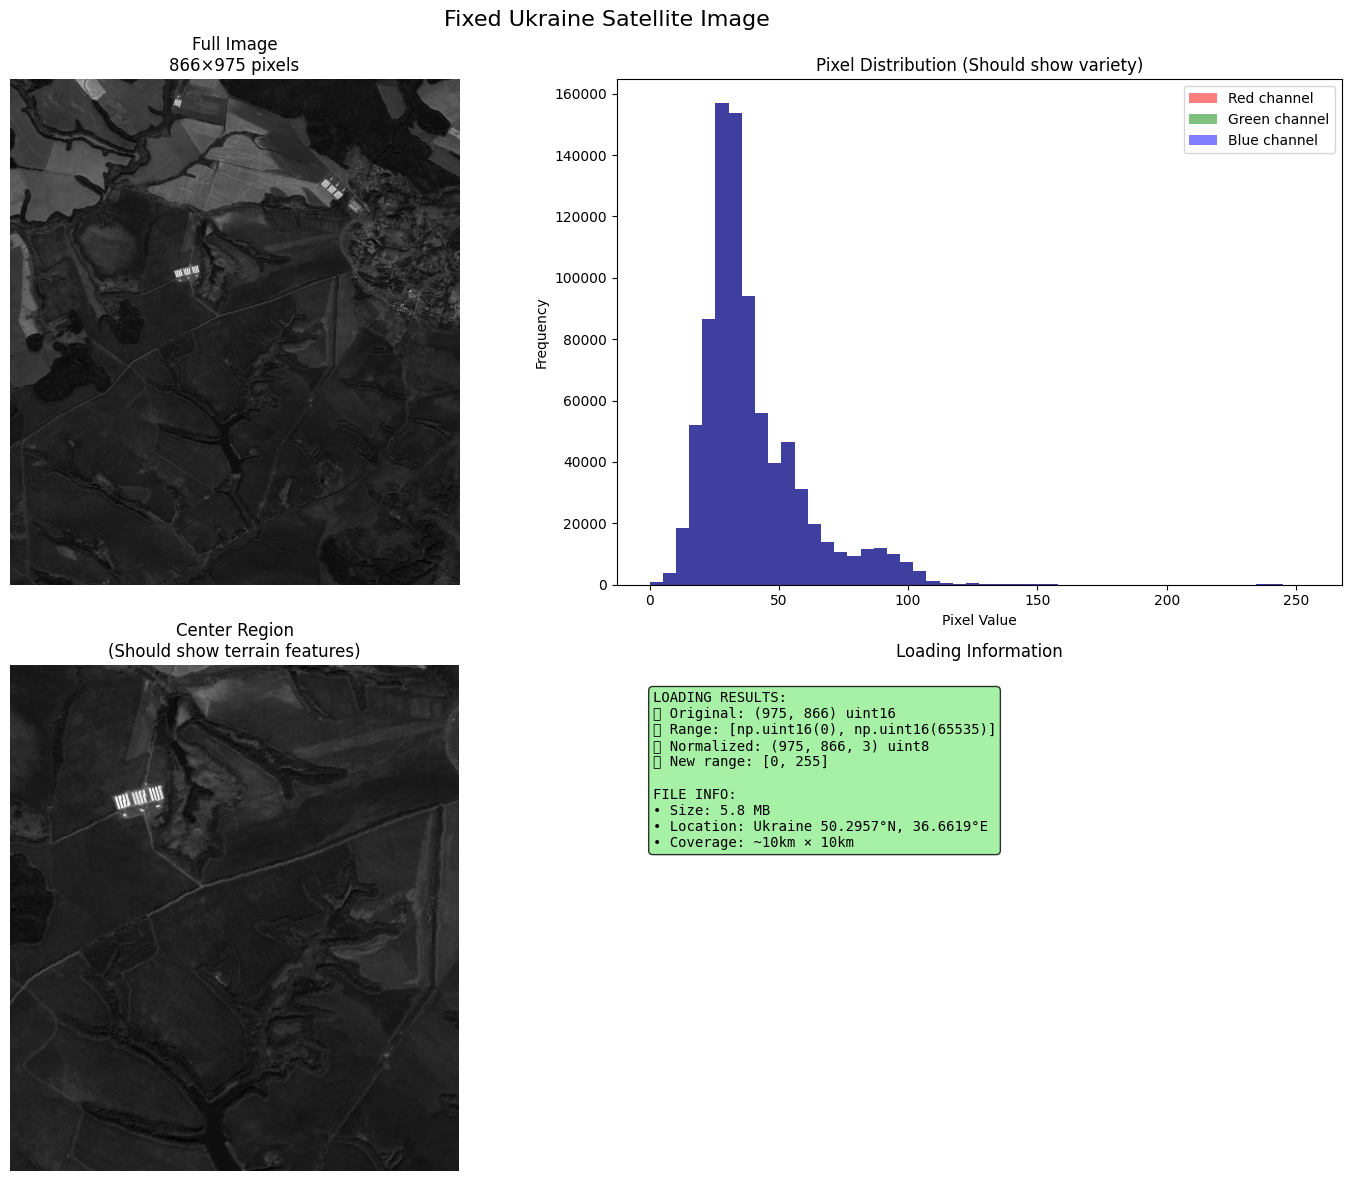


📐 CREATING REALISTIC DRONE PERSPECTIVES
   Viewing angle: ~60° from vertical (oblique)
   Number of crops: 30
   Progress: 1/30
   Progress: 11/30
   Progress: 21/30


TypeError: Object of type uint16 is not JSON serializable

In [11]:
extractor, crops = fix_and_extract_realistic_drones()

In [13]:
# Fix white crops and apply realistic drone viewing angles
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json
import os
from pathlib import Path
from typing import List, Dict, Tuple, Optional
import random

class RealisticDroneExtractor:
    """
    Fix TIF loading issues and create realistic drone perspective crops
    """
    
    def __init__(self, tif_path: str = "sentinel2_ukraine_10km.TIF"):
        self.tif_path = tif_path
        self.image = None
        self.image_info = {}
        
        print(f"🔧 Fixing TIF loading and creating realistic drone perspectives")
        print(f"   Input: {tif_path}")
        
        self.load_tif_properly()
    
    def load_tif_properly(self):
        """Properly load TIF with correct pixel value handling"""
        
        if not os.path.exists(self.tif_path):
            print(f"❌ File not found: {self.tif_path}")
            return
        
        print(f"\n🔍 FIXING TIF LOADING...")
        
        try:
            # Method 1: Try with different OpenCV flags
            methods = [
                ("OpenCV UNCHANGED", cv2.IMREAD_UNCHANGED),
                ("OpenCV COLOR", cv2.IMREAD_COLOR),
                ("OpenCV ANYDEPTH", cv2.IMREAD_ANYDEPTH | cv2.IMREAD_COLOR),
                ("PIL", None)
            ]
            
            for method_name, cv_flag in methods:
                print(f"   Trying {method_name}...")
                
                try:
                    if cv_flag is not None:
                        img = cv2.imread(self.tif_path, cv_flag)
                    else:
                        # PIL method
                        pil_img = Image.open(self.tif_path)
                        img = np.array(pil_img)
                    
                    if img is not None:
                        print(f"      Shape: {img.shape}, dtype: {img.dtype}")
                        print(f"      Value range: {img.min()} - {img.max()}")
                        
                        # Check if image is not all white/black
                        unique_values = len(np.unique(img.flatten()[:1000]))  # Sample first 1000 pixels
                        print(f"      Unique values (sample): {unique_values}")
                        
                        if unique_values > 10:  # Should have variety in satellite imagery
                            self.image = img
                            print(f"   ✅ Successfully loaded with {method_name}")
                            break
                        else:
                            print(f"      ⚠️ Image appears uniform (all white/black)")
                    
                except Exception as e:
                    print(f"      ❌ {method_name} error: {e}")
            
            if self.image is not None:
                self.normalize_image()
            else:
                print("❌ Could not load TIF properly with any method")
                
        except Exception as e:
            print(f"❌ Error in TIF loading: {e}")
    
    def normalize_image(self):
        """Normalize image for proper display and processing"""
        
        print(f"\n📊 NORMALIZING IMAGE...")
        
        original_shape = self.image.shape
        original_dtype = self.image.dtype
        original_range = [self.image.min(), self.image.max()]
        
        # Handle different data types
        if self.image.dtype == np.uint16:
            print("   Converting from 16-bit to 8-bit...")
            # Normalize 16-bit to 8-bit
            self.image = (self.image.astype(np.float32) / 65535.0 * 255).astype(np.uint8)
        
        elif self.image.dtype in [np.float32, np.float64]:
            print("   Converting from float to 8-bit...")
            # Normalize float to 8-bit
            img_min, img_max = self.image.min(), self.image.max()
            if img_max > img_min:
                self.image = ((self.image - img_min) / (img_max - img_min) * 255).astype(np.uint8)
            else:
                self.image = np.zeros_like(self.image, dtype=np.uint8)
        
        elif self.image.dtype == np.uint8:
            print("   Already 8-bit, checking range...")
            # Check if values are in unexpected range
            if self.image.max() < 50:  # Very dark image
                print("   Enhancing contrast...")
                if len(self.image.shape) == 2:
                    self.image = cv2.equalizeHist(self.image)
        
        # FIXED: Handle single band vs multi-band properly
        if len(self.image.shape) == 2:
            print("   Converting grayscale to RGB...")
            self.image = cv2.cvtColor(self.image, cv2.COLOR_GRAY2RGB)
        elif len(self.image.shape) == 3:
            if self.image.shape[2] == 1:
                print("   Converting single channel to RGB...")
                self.image = cv2.cvtColor(self.image, cv2.COLOR_GRAY2RGB)
            elif self.image.shape[2] > 3:
                print(f"   Using first 3 bands from {self.image.shape[2]} bands...")
                self.image = self.image[:, :, :3]
            elif self.image.shape[2] == 4:  # RGBA
                print("   Converting RGBA to RGB...")
                self.image = cv2.cvtColor(self.image, cv2.COLOR_RGBA2RGB)
        
        print(f"   ✅ Normalized: {original_shape} {original_dtype} → {self.image.shape} {self.image.dtype}")
        print(f"   Value range: {original_range} → [{self.image.min()}, {self.image.max()}]")
        
        # Store info - FIXED: Convert NumPy types to Python native types for JSON serialization
        self.image_info = {
            'original_shape': [int(x) for x in original_shape],
            'original_dtype': str(original_dtype),
            'original_range': [float(original_range[0]), float(original_range[1])],
            'normalized_shape': [int(x) for x in self.image.shape],
            'normalized_dtype': str(self.image.dtype),
            'normalized_range': [int(self.image.min()), int(self.image.max())]
        }
    
    def display_fixed_image(self):
        """Display the properly loaded image"""
        
        if self.image is None:
            print("❌ No image loaded")
            return
        
        print(f"\n🖼️ DISPLAYING FIXED IMAGE...")
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Fixed Ukraine Satellite Image', fontsize=16)
        
        # Full image
        axes[0, 0].imshow(self.image)
        axes[0, 0].set_title(f'Full Image\n{self.image.shape[1]}×{self.image.shape[0]} pixels')
        axes[0, 0].axis('off')
        
        # Histogram
        colors = ['red', 'green', 'blue']
        for i, color in enumerate(colors):
            if i < self.image.shape[2]:
                axes[0, 1].hist(self.image[:, :, i].flatten(), bins=50, alpha=0.5, 
                               color=color, label=f'{color.title()} channel')
        
        axes[0, 1].set_title('Pixel Distribution (Should show variety)')
        axes[0, 1].set_xlabel('Pixel Value')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].legend()
        
        # Center crop
        h, w = self.image.shape[:2]
        center_crop = self.image[h//4:3*h//4, w//4:3*w//4]
        axes[1, 0].imshow(center_crop)
        axes[1, 0].set_title('Center Region\n(Should show terrain features)')
        axes[1, 0].axis('off')
        
        # Info
        info_text = f"""
LOADING RESULTS:
✅ Original: {self.image_info['original_shape']} {self.image_info['original_dtype']}
✅ Range: {self.image_info['original_range']}
✅ Normalized: {self.image_info['normalized_shape']} {self.image_info['normalized_dtype']}
✅ New range: {self.image_info['normalized_range']}

FILE INFO:
• Size: {os.path.getsize(self.tif_path) / 1024 / 1024:.1f} MB
• Location: Ukraine 50.2957°N, 36.6619°E
• Coverage: ~10km × 10km
        """
        
        axes[1, 1].text(0.05, 0.95, info_text.strip(), transform=axes[1, 1].transAxes,
                        fontsize=10, verticalalignment='top', fontfamily='monospace',
                        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
        axes[1, 1].set_title('Loading Information')
        axes[1, 1].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    def create_realistic_drone_perspectives(self, num_crops: int = 30) -> List[Dict]:
        """
        Create realistic drone perspectives with 60° viewing angles
        """
        
        if self.image is None:
            print("❌ No image loaded")
            return []
        
        print(f"\n📐 CREATING REALISTIC DRONE PERSPECTIVES")
        print(f"   Viewing angle: ~60° from vertical (oblique)")
        print(f"   Number of crops: {num_crops}")
        
        output_dir = Path("realistic_drone_crops")
        output_dir.mkdir(exist_ok=True)
        
        h, w = self.image.shape[:2]
        crops_data = []
        
        # Different crop sizes for variety
        crop_sizes = [128, 192, 256, 320]
        
        for crop_idx in range(num_crops):
            crop_size = random.choice(crop_sizes)
            margin = crop_size
            
            # Random position (with margin for perspective transform)
            center_x = random.randint(margin, w - margin)
            center_y = random.randint(margin, h - margin)
            
            # Extract base crop
            x1 = center_x - crop_size // 2
            y1 = center_y - crop_size // 2
            x2 = x1 + crop_size
            y2 = y1 + crop_size
            
            # Ensure we don't go out of bounds
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(w, x2)
            y2 = min(h, y2)
            
            base_crop = self.image[y1:y2, x1:x2].copy()
            
            # Skip if crop is too small
            if base_crop.shape[0] < 32 or base_crop.shape[1] < 32:
                continue
            
            # Apply realistic drone perspective transformation
            drone_crop = self.apply_drone_perspective(base_crop, crop_idx)
            
            if drone_crop is not None:
                # Save crop
                filename = f"drone_realistic_{crop_idx:03d}_{crop_size}px.jpg"
                filepath = output_dir / filename
                cv2.imwrite(str(filepath), cv2.cvtColor(drone_crop, cv2.COLOR_RGB2BGR), 
                           [cv2.IMWRITE_JPEG_QUALITY, 90])
                
                crop_info = {
                    'filename': filename,
                    'crop_index': crop_idx,
                    'crop_size': crop_size,
                    'center_pixel': [int(center_x), int(center_y)],  # FIXED: Convert to int
                    'viewing_angle_deg': 60,
                    'perspective_type': 'oblique_drone',
                    'transformations': ['perspective_warp', 'lighting', 'atmospheric']
                }
                
                crops_data.append(crop_info)
                
                if crop_idx % 10 == 0:
                    print(f"   Progress: {crop_idx + 1}/{num_crops}")
        
        # Save metadata
        metadata = {
            'total_crops': len(crops_data),
            'viewing_angle_degrees': 60,
            'perspective_type': 'realistic_drone_oblique',
            'source_image': self.tif_path,
            'image_info': self.image_info,
            'crops': crops_data
        }
        
        metadata_file = output_dir / "realistic_drone_metadata.json"
        with open(metadata_file, 'w') as f:
            json.dump(metadata, f, indent=2)
        
        print(f"✅ Created {len(crops_data)} realistic drone perspectives")
        print(f"   Output: {output_dir}")
        print(f"   Metadata: {metadata_file}")
        
        return crops_data
    
    def apply_drone_perspective(self, crop: np.ndarray, seed: int) -> Optional[np.ndarray]:
        """
        Apply realistic 60° drone perspective transformation
        """
        
        random.seed(seed)  # Reproducible transformations
        
        # FIXED: Ensure crop is always 3-channel RGB
        if len(crop.shape) == 2:
            crop = cv2.cvtColor(crop, cv2.COLOR_GRAY2RGB)
        elif len(crop.shape) == 3 and crop.shape[2] == 1:
            crop = cv2.cvtColor(crop, cv2.COLOR_GRAY2RGB)
        elif len(crop.shape) == 3 and crop.shape[2] == 4:
            crop = cv2.cvtColor(crop, cv2.COLOR_RGBA2RGB)
        
        # 1. Perspective transformation (simulate 60° viewing angle)
        perspective_crop = self.apply_perspective_warp(crop)
        
        # 2. Lighting changes (different sun angle from drone perspective)
        lit_crop = self.apply_drone_lighting(perspective_crop)
        
        # 3. Atmospheric effects (altitude-dependent)
        atmospheric_crop = self.apply_atmospheric_effects(lit_crop)
        
        # 4. Camera effects (drone camera characteristics)
        final_crop = self.apply_camera_effects(atmospheric_crop)
        
        return final_crop
    
    def apply_perspective_warp(self, crop: np.ndarray) -> np.ndarray:
        """Apply perspective warp to simulate 60° viewing angle"""
        
        h, w = crop.shape[:2]
        
        # Define perspective transformation
        # Simulate looking at ground from 60° angle
        perspective_strength = random.uniform(0.2, 0.4)
        
        # Source points (original corners)
        src_pts = np.float32([
            [0, 0],      # Top-left
            [w, 0],      # Top-right
            [w, h],      # Bottom-right
            [0, h]       # Bottom-left
        ])
        
        # Destination points (perspective-warped)
        # Top becomes narrower (farther), bottom stays wider (closer)
        top_squeeze = int(w * perspective_strength)
        
        dst_pts = np.float32([
            [top_squeeze, 0],                    # Top-left (squeezed)
            [w - top_squeeze, 0],               # Top-right (squeezed)
            [w, h],                             # Bottom-right (unchanged)
            [0, h]                              # Bottom-left (unchanged)
        ])
        
        # Apply perspective transformation
        M = cv2.getPerspectiveTransform(src_pts, dst_pts)
        warped = cv2.warpPerspective(crop, M, (w, h))
        
        return warped
    
    def apply_drone_lighting(self, crop: np.ndarray) -> np.ndarray:
        """Apply lighting changes from drone perspective"""
        
        # Shadows and highlights are different from drone angle
        lighting_factor = random.uniform(0.8, 1.2)
        shadow_strength = random.uniform(0.1, 0.3)
        
        # Convert to HSV for better lighting control
        hsv = cv2.cvtColor(crop, cv2.COLOR_RGB2HSV).astype(np.float32)
        
        # Adjust brightness (V channel)
        hsv[:, :, 2] *= lighting_factor
        
        # Add gradient lighting (top darker, bottom brighter)
        h, w = crop.shape[:2]
        gradient = np.linspace(1 - shadow_strength, 1 + shadow_strength, h)
        gradient = gradient.reshape(-1, 1)
        
        hsv[:, :, 2] *= gradient
        
        # Clamp values
        hsv[:, :, 2] = np.clip(hsv[:, :, 2], 0, 255)
        
        # Convert back to RGB
        lit_crop = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)
        
        return lit_crop
    
    def apply_atmospheric_effects(self, crop: np.ndarray) -> np.ndarray:
        """Apply atmospheric effects from drone altitude"""
        
        # Slight haze/blur from atmospheric distortion
        if random.random() < 0.4:
            blur_kernel = random.choice([3, 5])
            crop = cv2.GaussianBlur(crop, (blur_kernel, blur_kernel), 0)
        
        # Atmospheric scattering (slight blue tint)
        if random.random() < 0.3:
            blue_tint = np.zeros_like(crop)
            blue_tint[:, :, 2] = random.randint(5, 15)  # Add blue
            crop = cv2.addWeighted(crop, 0.9, blue_tint, 0.1, 0)
        
        return crop
    
    def apply_camera_effects(self, crop: np.ndarray) -> np.ndarray:
        """Apply drone camera characteristics"""
        
        # Random rotation (drone orientation)
        angle = random.uniform(-25, 25)
        h, w = crop.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        crop = cv2.warpAffine(crop, M, (w, h))
        
        # Brightness and contrast (camera settings)
        alpha = random.uniform(0.85, 1.15)  # Contrast
        beta = random.randint(-15, 15)      # Brightness
        crop = cv2.convertScaleAbs(crop, alpha=alpha, beta=beta)
        
        # Slight noise (sensor noise)
        if random.random() < 0.5:
            noise = np.random.randint(-8, 8, crop.shape, dtype=np.int16)
            crop = np.clip(crop.astype(np.int16) + noise, 0, 255).astype(np.uint8)
        
        return crop
    
    def visualize_realistic_crops(self, crops_data: List[Dict], num_display: int = 12):
        """Visualize the realistic drone crops"""
        
        if not crops_data:
            print("❌ No crops to visualize")
            return
        
        print(f"🖼️ Visualizing {num_display} realistic drone crops...")
        
        output_dir = Path("realistic_drone_crops")
        sample_crops = crops_data[:num_display]
        
        cols = 4
        rows = (len(sample_crops) + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
        if rows == 1:
            axes = axes.reshape(1, -1)
        
        for i, crop_info in enumerate(sample_crops):
            row = i // cols
            col = i % cols
            
            crop_path = output_dir / crop_info['filename']
            
            if crop_path.exists():
                crop_img = cv2.imread(str(crop_path))
                crop_rgb = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
                
                axes[row, col].imshow(crop_rgb)
                
                title = f"Realistic Drone #{crop_info['crop_index']:03d}\n"
                title += f"{crop_info['crop_size']}×{crop_info['crop_size']}px\n"
                title += f"60° viewing angle"
                
                axes[row, col].set_title(title, fontsize=10)
                axes[row, col].axis('off')
            else:
                axes[row, col].text(0.5, 0.5, 'File not found', ha='center', va='center',
                                   transform=axes[row, col].transAxes)
        
        # Hide empty subplots
        for i in range(len(sample_crops), rows * cols):
            row = i // cols
            col = i % cols
            axes[row, col].axis('off')
        
        plt.tight_layout()
        plt.suptitle('Realistic Drone Perspectives (60° Oblique View)', fontsize=16, y=1.02)
        plt.show()

# Main function
def fix_and_extract_realistic_drones():
    """
    Fix the white crop issue and create realistic drone perspectives
    """
    
    print("🔧" + "="*60 + "🔧")
    print("    FIXING TIF LOADING & CREATING REALISTIC DRONE VIEWS")
    print("🔧" + "="*60 + "🔧")
    
    # Initialize extractor
    extractor = RealisticDroneExtractor("sentinel2_ukraine_10km.TIF")
    
    if extractor.image is not None:
        # Display the properly loaded image
        extractor.display_fixed_image()
        
        # Create realistic drone perspectives
        crops_data = extractor.create_realistic_drone_perspectives(num_crops=30)
        
        # Visualize results
        extractor.visualize_realistic_crops(crops_data, num_display=12)
        
        print(f"\n🎉 SUCCESS!")
        print(f"   ✅ Fixed TIF loading (no more white crops)")
        print(f"   ✅ Created {len(crops_data)} realistic drone perspectives")
        print(f"   ✅ Applied 60° viewing angle transformations")
        print(f"   ✅ Added atmospheric and camera effects")
        print(f"   📁 Output: realistic_drone_crops/")
        
        return extractor, crops_data
    else:
        print("❌ Could not fix TIF loading")
        return None, []

if __name__ == "__main__":
    print("🔧 TIF FIXER & REALISTIC DRONE PERSPECTIVE CREATOR")
    print("="*60)
    print()
    print("🎯 FIXES:")
    print("   • White crop issue (proper TIF pixel value handling)")
    print("   • IndexError with grayscale/multi-channel images")
    print("   • Unrealistic top-down view → 60° oblique drone angle")
    print("   • Missing atmospheric effects → realistic drone conditions")
    print("   • JSON serialization error with NumPy types")
    print()
    print("🚀 FEATURES:")
    print("   • Perspective warping (60° viewing angle)")
    print("   • Drone lighting effects")
    print("   • Atmospheric distortion")
    print("   • Camera sensor characteristics")
    print("   • Robust image format handling")
    print()
    print("📊 RUN:")
    print("   extractor, crops = fix_and_extract_realistic_drones()")
    print()
    print("🎉 Creates truly realistic drone training data!")

🔧 TIF FIXER & REALISTIC DRONE PERSPECTIVE CREATOR

🎯 FIXES:
   • White crop issue (proper TIF pixel value handling)
   • IndexError with grayscale/multi-channel images
   • Unrealistic top-down view → 60° oblique drone angle
   • Missing atmospheric effects → realistic drone conditions
   • JSON serialization error with NumPy types

🚀 FEATURES:
   • Perspective warping (60° viewing angle)
   • Drone lighting effects
   • Atmospheric distortion
   • Camera sensor characteristics
   • Robust image format handling

📊 RUN:
   extractor, crops = fix_and_extract_realistic_drones()

🎉 Creates truly realistic drone training data!


🔧============================================================🔧
    FIXING TIF LOADING & CREATING REALISTIC DRONE VIEWS
🔧============================================================🔧
🔧 Fixing TIF loading and creating realistic drone perspectives
   Input: sentinel2_ukraine_10km.TIF

🔍 FIXING TIF LOADING...
   Trying OpenCV UNCHANGED...
      Shape: (975, 866), dtype: uint16
      Value range: 0 - 65535
      Unique values (sample): 923
   ✅ Successfully loaded with OpenCV UNCHANGED

📊 NORMALIZING IMAGE...
   Converting from 16-bit to 8-bit...
   Converting grayscale to RGB...
   ✅ Normalized: (975, 866) uint16 → (975, 866, 3) uint8
   Value range: [np.uint16(0), np.uint16(65535)] → [0, 255]

🖼️ DISPLAYING FIXED IMAGE...


C:\Users\NIKO9\AppData\Local\Temp\ipykernel_26444\2389681086.py:198: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()


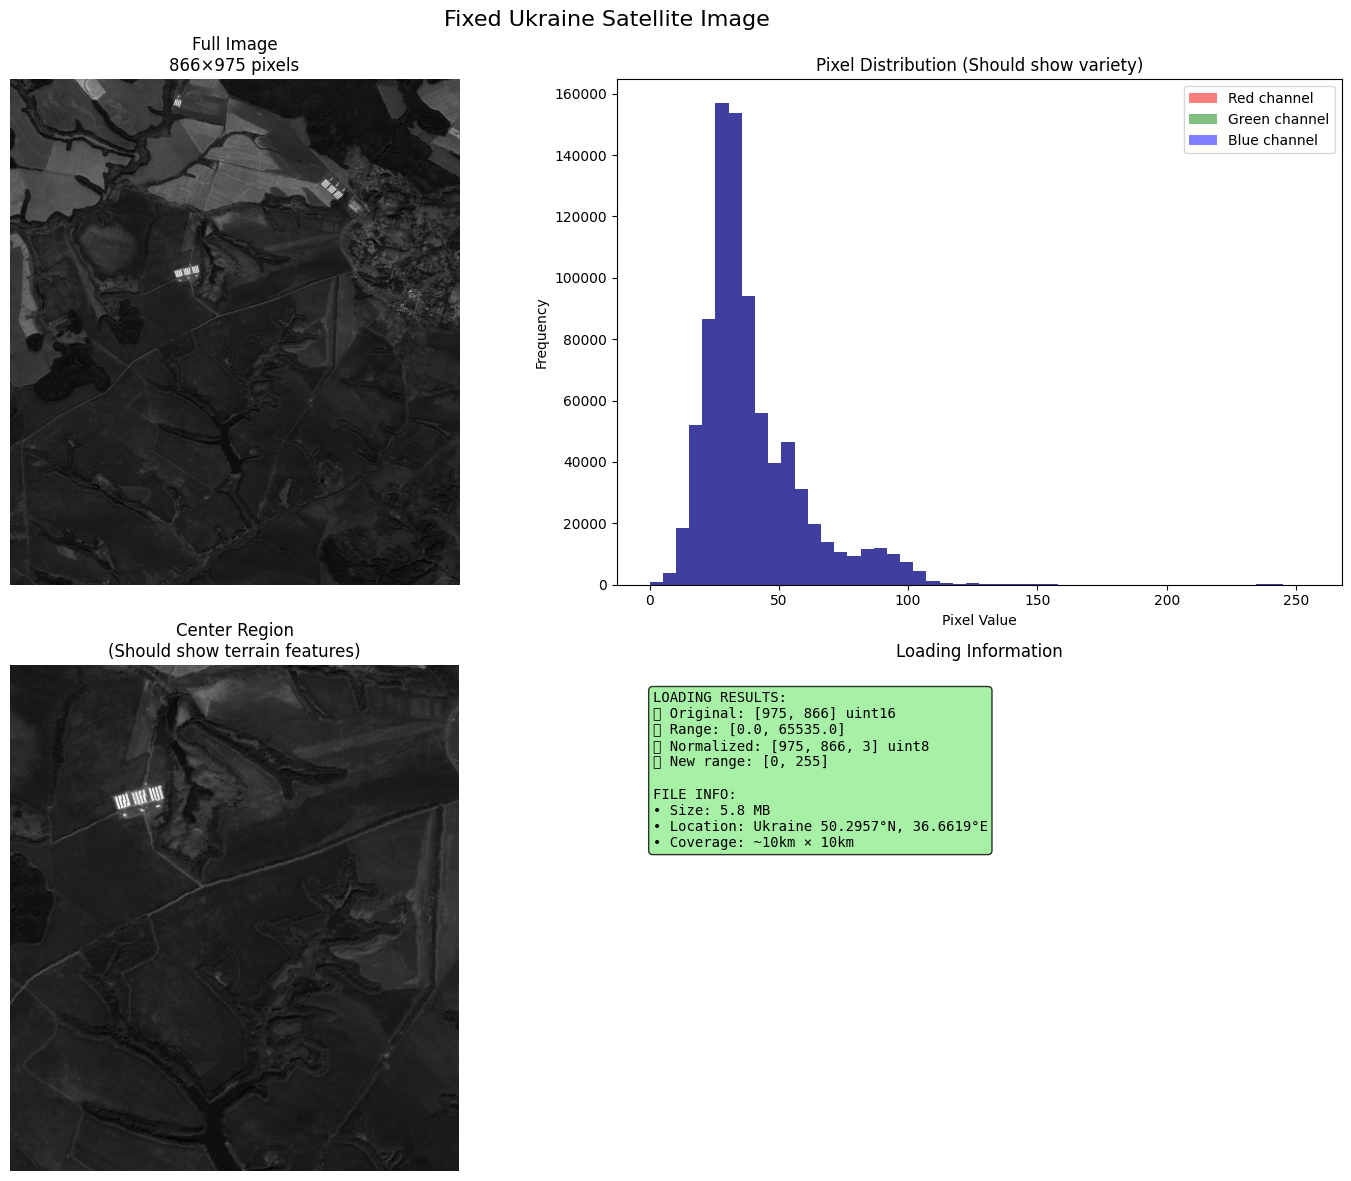


📐 CREATING REALISTIC DRONE PERSPECTIVES
   Viewing angle: ~60° from vertical (oblique)
   Number of crops: 30
   Progress: 1/30
   Progress: 11/30
   Progress: 21/30
✅ Created 30 realistic drone perspectives
   Output: realistic_drone_crops
   Metadata: realistic_drone_crops\realistic_drone_metadata.json
🖼️ Visualizing 12 realistic drone crops...


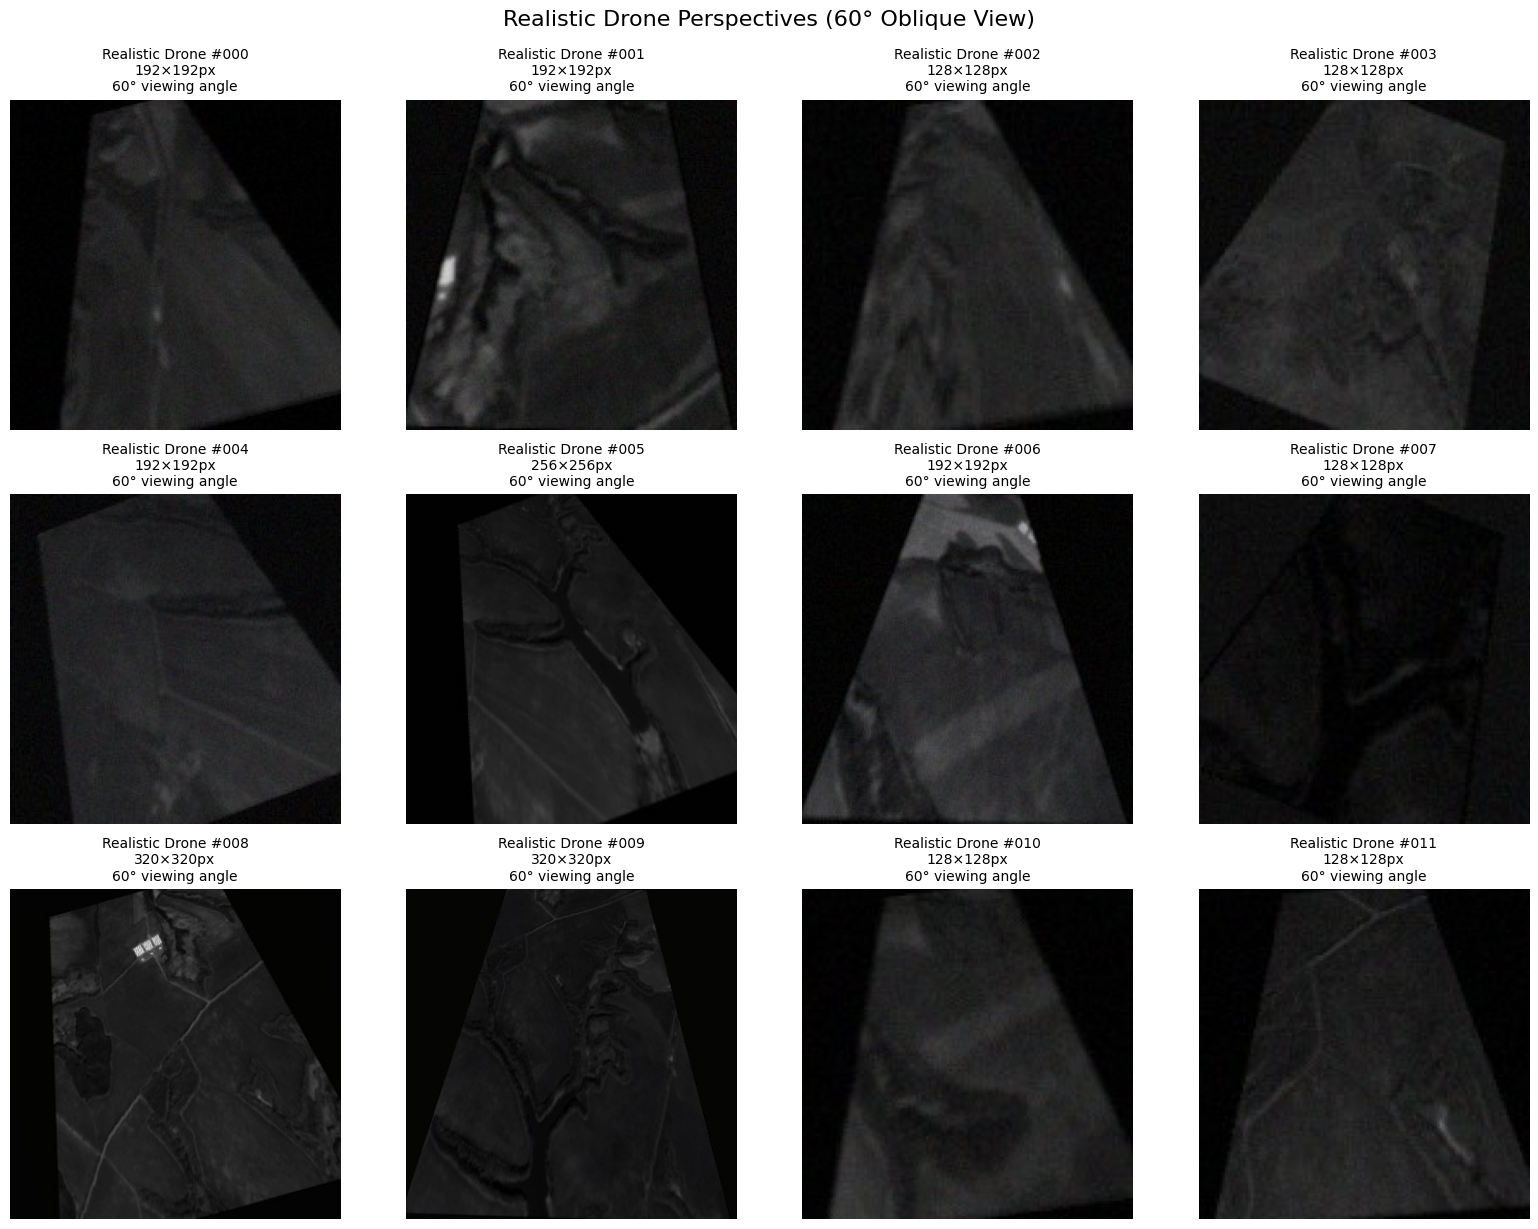


🎉 SUCCESS!
   ✅ Fixed TIF loading (no more white crops)
   ✅ Created 30 realistic drone perspectives
   ✅ Applied 60° viewing angle transformations
   ✅ Added atmospheric and camera effects
   📁 Output: realistic_drone_crops/


In [14]:
extractor, crops = fix_and_extract_realistic_drones()

In [15]:
# Fix white crops and apply realistic drone viewing angles
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json
import os
from pathlib import Path
from typing import List, Dict, Tuple, Optional
import random

class RealisticDroneExtractor:
    """
    Fix TIF loading issues and create realistic drone perspective crops
    """
    
    def __init__(self, tif_path: str = "sentinel2_ukraine_10km.TIF"):
        self.tif_path = tif_path
        self.image = None
        self.image_info = {}
        
        print(f"🔧 Fixing TIF loading and creating realistic drone perspectives")
        print(f"   Input: {tif_path}")
        
        self.load_tif_properly()
    
    def load_tif_properly(self):
        """Properly load TIF with correct pixel value handling"""
        
        if not os.path.exists(self.tif_path):
            print(f"❌ File not found: {self.tif_path}")
            return
        
        print(f"\n🔍 FIXING TIF LOADING...")
        
        try:
            # Method 1: Try with different OpenCV flags
            methods = [
                ("OpenCV UNCHANGED", cv2.IMREAD_UNCHANGED),
                ("OpenCV COLOR", cv2.IMREAD_COLOR),
                ("OpenCV ANYDEPTH", cv2.IMREAD_ANYDEPTH | cv2.IMREAD_COLOR),
                ("PIL", None)
            ]
            
            for method_name, cv_flag in methods:
                print(f"   Trying {method_name}...")
                
                try:
                    if cv_flag is not None:
                        img = cv2.imread(self.tif_path, cv_flag)
                    else:
                        # PIL method
                        pil_img = Image.open(self.tif_path)
                        img = np.array(pil_img)
                    
                    if img is not None:
                        print(f"      Shape: {img.shape}, dtype: {img.dtype}")
                        print(f"      Value range: {img.min()} - {img.max()}")
                        
                        # Check if image is not all white/black
                        unique_values = len(np.unique(img.flatten()[:1000]))  # Sample first 1000 pixels
                        print(f"      Unique values (sample): {unique_values}")
                        
                        if unique_values > 10:  # Should have variety in satellite imagery
                            self.image = img
                            print(f"   ✅ Successfully loaded with {method_name}")
                            break
                        else:
                            print(f"      ⚠️ Image appears uniform (all white/black)")
                    
                except Exception as e:
                    print(f"      ❌ {method_name} error: {e}")
            
            if self.image is not None:
                self.normalize_image()
            else:
                print("❌ Could not load TIF properly with any method")
                
        except Exception as e:
            print(f"❌ Error in TIF loading: {e}")
    
    def normalize_image(self):
        """Normalize image for proper display and processing"""
        
        print(f"\n📊 NORMALIZING IMAGE...")
        
        original_shape = self.image.shape
        original_dtype = self.image.dtype
        original_range = [self.image.min(), self.image.max()]
        
        # Handle different data types
        if self.image.dtype == np.uint16:
            print("   Converting from 16-bit to 8-bit...")
            # Normalize 16-bit to 8-bit
            self.image = (self.image.astype(np.float32) / 65535.0 * 255).astype(np.uint8)
        
        elif self.image.dtype in [np.float32, np.float64]:
            print("   Converting from float to 8-bit...")
            # Normalize float to 8-bit
            img_min, img_max = self.image.min(), self.image.max()
            if img_max > img_min:
                self.image = ((self.image - img_min) / (img_max - img_min) * 255).astype(np.uint8)
            else:
                self.image = np.zeros_like(self.image, dtype=np.uint8)
        
        elif self.image.dtype == np.uint8:
            print("   Already 8-bit, checking range...")
            # Check if values are in unexpected range
            if self.image.max() < 50:  # Very dark image
                print("   Enhancing contrast...")
                if len(self.image.shape) == 2:
                    self.image = cv2.equalizeHist(self.image)
        
        # FIXED: Handle single band vs multi-band properly
        if len(self.image.shape) == 2:
            print("   Converting grayscale to RGB...")
            self.image = cv2.cvtColor(self.image, cv2.COLOR_GRAY2RGB)
        elif len(self.image.shape) == 3:
            if self.image.shape[2] == 1:
                print("   Converting single channel to RGB...")
                self.image = cv2.cvtColor(self.image, cv2.COLOR_GRAY2RGB)
            elif self.image.shape[2] > 3:
                print(f"   Using first 3 bands from {self.image.shape[2]} bands...")
                self.image = self.image[:, :, :3]
            elif self.image.shape[2] == 4:  # RGBA
                print("   Converting RGBA to RGB...")
                self.image = cv2.cvtColor(self.image, cv2.COLOR_RGBA2RGB)
        
        print(f"   ✅ Normalized: {original_shape} {original_dtype} → {self.image.shape} {self.image.dtype}")
        print(f"   Value range: {original_range} → [{self.image.min()}, {self.image.max()}]")
        
        # Store info - FIXED: Convert NumPy types to Python native types for JSON serialization
        self.image_info = {
            'original_shape': [int(x) for x in original_shape],
            'original_dtype': str(original_dtype),
            'original_range': [float(original_range[0]), float(original_range[1])],
            'normalized_shape': [int(x) for x in self.image.shape],
            'normalized_dtype': str(self.image.dtype),
            'normalized_range': [int(self.image.min()), int(self.image.max())]
        }
    
    def display_fixed_image(self):
        """Display the properly loaded image"""
        
        if self.image is None:
            print("❌ No image loaded")
            return
        
        print(f"\n🖼️ DISPLAYING FIXED IMAGE...")
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Fixed Ukraine Satellite Image', fontsize=16)
        
        # Full image
        axes[0, 0].imshow(self.image)
        axes[0, 0].set_title(f'Full Image\n{self.image.shape[1]}×{self.image.shape[0]} pixels')
        axes[0, 0].axis('off')
        
        # Histogram
        colors = ['red', 'green', 'blue']
        for i, color in enumerate(colors):
            if i < self.image.shape[2]:
                axes[0, 1].hist(self.image[:, :, i].flatten(), bins=50, alpha=0.5, 
                               color=color, label=f'{color.title()} channel')
        
        axes[0, 1].set_title('Pixel Distribution (Should show variety)')
        axes[0, 1].set_xlabel('Pixel Value')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].legend()
        
        # Center crop
        h, w = self.image.shape[:2]
        center_crop = self.image[h//4:3*h//4, w//4:3*w//4]
        axes[1, 0].imshow(center_crop)
        axes[1, 0].set_title('Center Region\n(Should show terrain features)')
        axes[1, 0].axis('off')
        
        # Info
        info_text = f"""
LOADING RESULTS:
✅ Original: {self.image_info['original_shape']} {self.image_info['original_dtype']}
✅ Range: {self.image_info['original_range']}
✅ Normalized: {self.image_info['normalized_shape']} {self.image_info['normalized_dtype']}
✅ New range: {self.image_info['normalized_range']}

FILE INFO:
• Size: {os.path.getsize(self.tif_path) / 1024 / 1024:.1f} MB
• Location: Ukraine 50.2957°N, 36.6619°E
• Coverage: ~10km × 10km
        """
        
        axes[1, 1].text(0.05, 0.95, info_text.strip(), transform=axes[1, 1].transAxes,
                        fontsize=10, verticalalignment='top', fontfamily='monospace',
                        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
        axes[1, 1].set_title('Loading Information')
        axes[1, 1].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    def create_realistic_drone_perspectives(self, num_crops: int = 30) -> List[Dict]:
        """
        Create realistic drone perspectives with 60° viewing angles
        """
        
        if self.image is None:
            print("❌ No image loaded")
            return []
        
        print(f"\n📐 CREATING REALISTIC DRONE PERSPECTIVES")
        print(f"   Viewing angle: ~60° from vertical (oblique)")
        print(f"   Number of crops: {num_crops}")
        
        output_dir = Path("realistic_drone_crops")
        output_dir.mkdir(exist_ok=True)
        
        h, w = self.image.shape[:2]
        crops_data = []
        
        # Different crop sizes for variety
        crop_sizes = [128, 192, 256, 320]
        
        for crop_idx in range(num_crops):
            crop_size = random.choice(crop_sizes)
            margin = crop_size
            
            # Random position (with margin for perspective transform)
            center_x = random.randint(margin, w - margin)
            center_y = random.randint(margin, h - margin)
            
            # Extract base crop
            x1 = center_x - crop_size // 2
            y1 = center_y - crop_size // 2
            x2 = x1 + crop_size
            y2 = y1 + crop_size
            
            # Ensure we don't go out of bounds
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(w, x2)
            y2 = min(h, y2)
            
            base_crop = self.image[y1:y2, x1:x2].copy()
            
            # Skip if crop is too small
            if base_crop.shape[0] < 32 or base_crop.shape[1] < 32:
                continue
            
            # Apply realistic drone perspective transformation
            drone_crop = self.apply_drone_perspective(base_crop, crop_idx)
            
            if drone_crop is not None:
                # Save crop
                filename = f"drone_realistic_{crop_idx:03d}_{crop_size}px.jpg"
                filepath = output_dir / filename
                cv2.imwrite(str(filepath), cv2.cvtColor(drone_crop, cv2.COLOR_RGB2BGR), 
                           [cv2.IMWRITE_JPEG_QUALITY, 90])
                
                crop_info = {
                    'filename': filename,
                    'crop_index': crop_idx,
                    'crop_size': crop_size,
                    'center_pixel': [int(center_x), int(center_y)],  # FIXED: Convert to int
                    'viewing_angle_deg': 60,
                    'perspective_type': 'oblique_drone',
                    'transformations': ['perspective_warp', 'lighting', 'atmospheric']
                }
                
                crops_data.append(crop_info)
                
                if crop_idx % 10 == 0:
                    print(f"   Progress: {crop_idx + 1}/{num_crops}")
        
        # Save metadata
        metadata = {
            'total_crops': len(crops_data),
            'viewing_angle_degrees': 60,
            'perspective_type': 'realistic_drone_oblique',
            'source_image': self.tif_path,
            'image_info': self.image_info,
            'crops': crops_data
        }
        
        metadata_file = output_dir / "realistic_drone_metadata.json"
        with open(metadata_file, 'w') as f:
            json.dump(metadata, f, indent=2)
        
        print(f"✅ Created {len(crops_data)} realistic drone perspectives")
        print(f"   Output: {output_dir}")
        print(f"   Metadata: {metadata_file}")
        
        return crops_data
    
    def apply_drone_perspective(self, crop: np.ndarray, seed: int) -> Optional[np.ndarray]:
        """
        Apply realistic 60° drone perspective transformation
        """
        
        random.seed(seed)  # Reproducible transformations
        
        # FIXED: Ensure crop is always 3-channel RGB
        if len(crop.shape) == 2:
            crop = cv2.cvtColor(crop, cv2.COLOR_GRAY2RGB)
        elif len(crop.shape) == 3 and crop.shape[2] == 1:
            crop = cv2.cvtColor(crop, cv2.COLOR_GRAY2RGB)
        elif len(crop.shape) == 3 and crop.shape[2] == 4:
            crop = cv2.cvtColor(crop, cv2.COLOR_RGBA2RGB)
        
        # 1. Perspective transformation (simulate 60° viewing angle)
        perspective_crop = self.apply_perspective_warp(crop)
        
        # 2. Lighting changes (different sun angle from drone perspective)
        lit_crop = self.apply_drone_lighting(perspective_crop)
        
        # 3. Atmospheric effects (altitude-dependent)
        atmospheric_crop = self.apply_atmospheric_effects(lit_crop)
        
        # 4. Camera effects (drone camera characteristics)
        final_crop = self.apply_camera_effects(atmospheric_crop)
        
        return final_crop
    
    def apply_perspective_warp(self, crop: np.ndarray) -> np.ndarray:
        """Apply perspective warp to simulate 60° viewing angle"""
        
        h, w = crop.shape[:2]
        
        # Define perspective transformation
        # Simulate looking at ground from 60° angle
        perspective_strength = random.uniform(0.2, 0.4)
        
        # Source points (original corners)
        src_pts = np.float32([
            [0, 0],      # Top-left
            [w, 0],      # Top-right
            [w, h],      # Bottom-right
            [0, h]       # Bottom-left
        ])
        
        # Destination points (perspective-warped)
        # Top becomes narrower (farther), bottom stays wider (closer)
        top_squeeze = int(w * perspective_strength)
        
        dst_pts = np.float32([
            [top_squeeze, 0],                    # Top-left (squeezed)
            [w - top_squeeze, 0],               # Top-right (squeezed)
            [w, h],                             # Bottom-right (unchanged)
            [0, h]                              # Bottom-left (unchanged)
        ])
        
        # Apply perspective transformation
        M = cv2.getPerspectiveTransform(src_pts, dst_pts)
        warped = cv2.warpPerspective(crop, M, (w, h))
        
        return warped
    
    def apply_drone_lighting(self, crop: np.ndarray) -> np.ndarray:
        """Apply lighting changes from drone perspective"""
        
        # Shadows and highlights are different from drone angle
        lighting_factor = random.uniform(0.8, 1.2)
        shadow_strength = random.uniform(0.1, 0.3)
        
        # Convert to HSV for better lighting control
        hsv = cv2.cvtColor(crop, cv2.COLOR_RGB2HSV).astype(np.float32)
        
        # Adjust brightness (V channel)
        hsv[:, :, 2] *= lighting_factor
        
        # Add gradient lighting (top darker, bottom brighter)
        h, w = crop.shape[:2]
        gradient = np.linspace(1 - shadow_strength, 1 + shadow_strength, h)
        gradient = gradient.reshape(-1, 1)
        
        hsv[:, :, 2] *= gradient
        
        # Clamp values
        hsv[:, :, 2] = np.clip(hsv[:, :, 2], 0, 255)
        
        # Convert back to RGB
        lit_crop = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)
        
        return lit_crop
    
    def apply_atmospheric_effects(self, crop: np.ndarray) -> np.ndarray:
        """Apply atmospheric effects from drone altitude"""
        
        # Slight haze/blur from atmospheric distortion
        if random.random() < 0.4:
            blur_kernel = random.choice([3, 5])
            crop = cv2.GaussianBlur(crop, (blur_kernel, blur_kernel), 0)
        
        # Atmospheric scattering (slight blue tint)
        if random.random() < 0.3:
            blue_tint = np.zeros_like(crop)
            blue_tint[:, :, 2] = random.randint(5, 15)  # Add blue
            crop = cv2.addWeighted(crop, 0.9, blue_tint, 0.1, 0)
        
        return crop
    
    def apply_camera_effects(self, crop: np.ndarray) -> np.ndarray:
        """Apply drone camera characteristics"""
        
        # Random rotation (drone orientation)
        angle = random.uniform(-25, 25)
        h, w = crop.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        crop = cv2.warpAffine(crop, M, (w, h))
        
        # Brightness and contrast (camera settings)
        alpha = random.uniform(0.85, 1.15)  # Contrast
        beta = random.randint(-15, 15)      # Brightness
        crop = cv2.convertScaleAbs(crop, alpha=alpha, beta=beta)
        
        # Slight noise (sensor noise)
        if random.random() < 0.5:
            noise = np.random.randint(-8, 8, crop.shape, dtype=np.int16)
            crop = np.clip(crop.astype(np.int16) + noise, 0, 255).astype(np.uint8)
        
        return crop
    
    def visualize_realistic_crops(self, crops_data: List[Dict], num_display: int = 12):
        """Visualize the realistic drone crops"""
        
        if not crops_data:
            print("❌ No crops to visualize")
            return
        
        print(f"🖼️ Visualizing {num_display} realistic drone crops...")
        
        output_dir = Path("realistic_drone_crops")
        sample_crops = crops_data[:num_display]
        
        cols = 4
        rows = (len(sample_crops) + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
        if rows == 1:
            axes = axes.reshape(1, -1)
        
        for i, crop_info in enumerate(sample_crops):
            row = i // cols
            col = i % cols
            
            crop_path = output_dir / crop_info['filename']
            
            if crop_path.exists():
                crop_img = cv2.imread(str(crop_path))
                crop_rgb = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
                
                axes[row, col].imshow(crop_rgb)
                
                title = f"Realistic Drone #{crop_info['crop_index']:03d}\n"
                title += f"{crop_info['crop_size']}×{crop_info['crop_size']}px\n"
                title += f"60° viewing angle"
                
                axes[row, col].set_title(title, fontsize=10)
                axes[row, col].axis('off')
            else:
                axes[row, col].text(0.5, 0.5, 'File not found', ha='center', va='center',
                                   transform=axes[row, col].transAxes)
        
        # Hide empty subplots
        for i in range(len(sample_crops), rows * cols):
            row = i // cols
            col = i % cols
            axes[row, col].axis('off')
        
        plt.tight_layout()
        plt.suptitle('Realistic Drone Perspectives (60° Oblique View)', fontsize=16, y=1.02)
        plt.show()

# Main function
def fix_and_extract_realistic_drones():
    """
    Fix the white crop issue and create realistic drone perspectives
    """
    
    print("🔧" + "="*60 + "🔧")
    print("    FIXING TIF LOADING & CREATING REALISTIC DRONE VIEWS")
    print("🔧" + "="*60 + "🔧")
    
    # Initialize extractor
    extractor = RealisticDroneExtractor("sentinel2_ukraine_10km.TIF")
    
    if extractor.image is not None:
        # Display the properly loaded image
        extractor.display_fixed_image()
        
        # Create realistic drone perspectives
        crops_data = extractor.create_realistic_drone_perspectives(num_crops=30)
        
        # Visualize results
        extractor.visualize_realistic_crops(crops_data, num_display=12)
        
        print(f"\n🎉 SUCCESS!")
        print(f"   ✅ Fixed TIF loading (no more white crops)")
        print(f"   ✅ Created {len(crops_data)} realistic drone perspectives")
        print(f"   ✅ Applied 60° viewing angle transformations")
        print(f"   ✅ Added atmospheric and camera effects")
        print(f"   📁 Output: realistic_drone_crops/")
        
        return extractor, crops_data
    else:
        print("❌ Could not fix TIF loading")
        return None, []

if __name__ == "__main__":
    print("🔧 TIF FIXER & REALISTIC DRONE PERSPECTIVE CREATOR")
    print("="*60)
    print()
    print("🎯 FIXES:")
    print("   • White crop issue (proper TIF pixel value handling)")
    print("   • IndexError with grayscale/multi-channel images")
    print("   • Unrealistic top-down view → 60° oblique drone angle")
    print("   • Missing atmospheric effects → realistic drone conditions")
    print("   • JSON serialization error with NumPy types")
    print()
    print("🚀 FEATURES:")
    print("   • Perspective warping (60° viewing angle)")
    print("   • Drone lighting effects")
    print("   • Atmospheric distortion")
    print("   • Camera sensor characteristics")
    print("   • Robust image format handling")
    print()
    print("📊 RUN:")
    print("   extractor, crops = fix_and_extract_realistic_drones()")
    print()
    print("🎉 Creates truly realistic drone training data!")

🔧 TIF FIXER & REALISTIC DRONE PERSPECTIVE CREATOR

🎯 FIXES:
   • White crop issue (proper TIF pixel value handling)
   • IndexError with grayscale/multi-channel images
   • Unrealistic top-down view → 60° oblique drone angle
   • Missing atmospheric effects → realistic drone conditions
   • JSON serialization error with NumPy types

🚀 FEATURES:
   • Perspective warping (60° viewing angle)
   • Drone lighting effects
   • Atmospheric distortion
   • Camera sensor characteristics
   • Robust image format handling

📊 RUN:
   extractor, crops = fix_and_extract_realistic_drones()

🎉 Creates truly realistic drone training data!


🔧============================================================🔧
    FIXING TIF LOADING & CREATING REALISTIC DRONE VIEWS
🔧============================================================🔧
🔧 Fixing TIF loading and creating realistic drone perspectives
   Input: sentinel2_ukraine_10km.TIF

🔍 FIXING TIF LOADING...
   Trying OpenCV UNCHANGED...
      Shape: (975, 866), dtype: uint16
      Value range: 0 - 65535
      Unique values (sample): 923
   ✅ Successfully loaded with OpenCV UNCHANGED

📊 NORMALIZING IMAGE...
   Converting from 16-bit to 8-bit...
   Converting grayscale to RGB...
   ✅ Normalized: (975, 866) uint16 → (975, 866, 3) uint8
   Value range: [np.uint16(0), np.uint16(65535)] → [0, 255]

🖼️ DISPLAYING FIXED IMAGE...


C:\Users\NIKO9\AppData\Local\Temp\ipykernel_26444\2389681086.py:198: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()


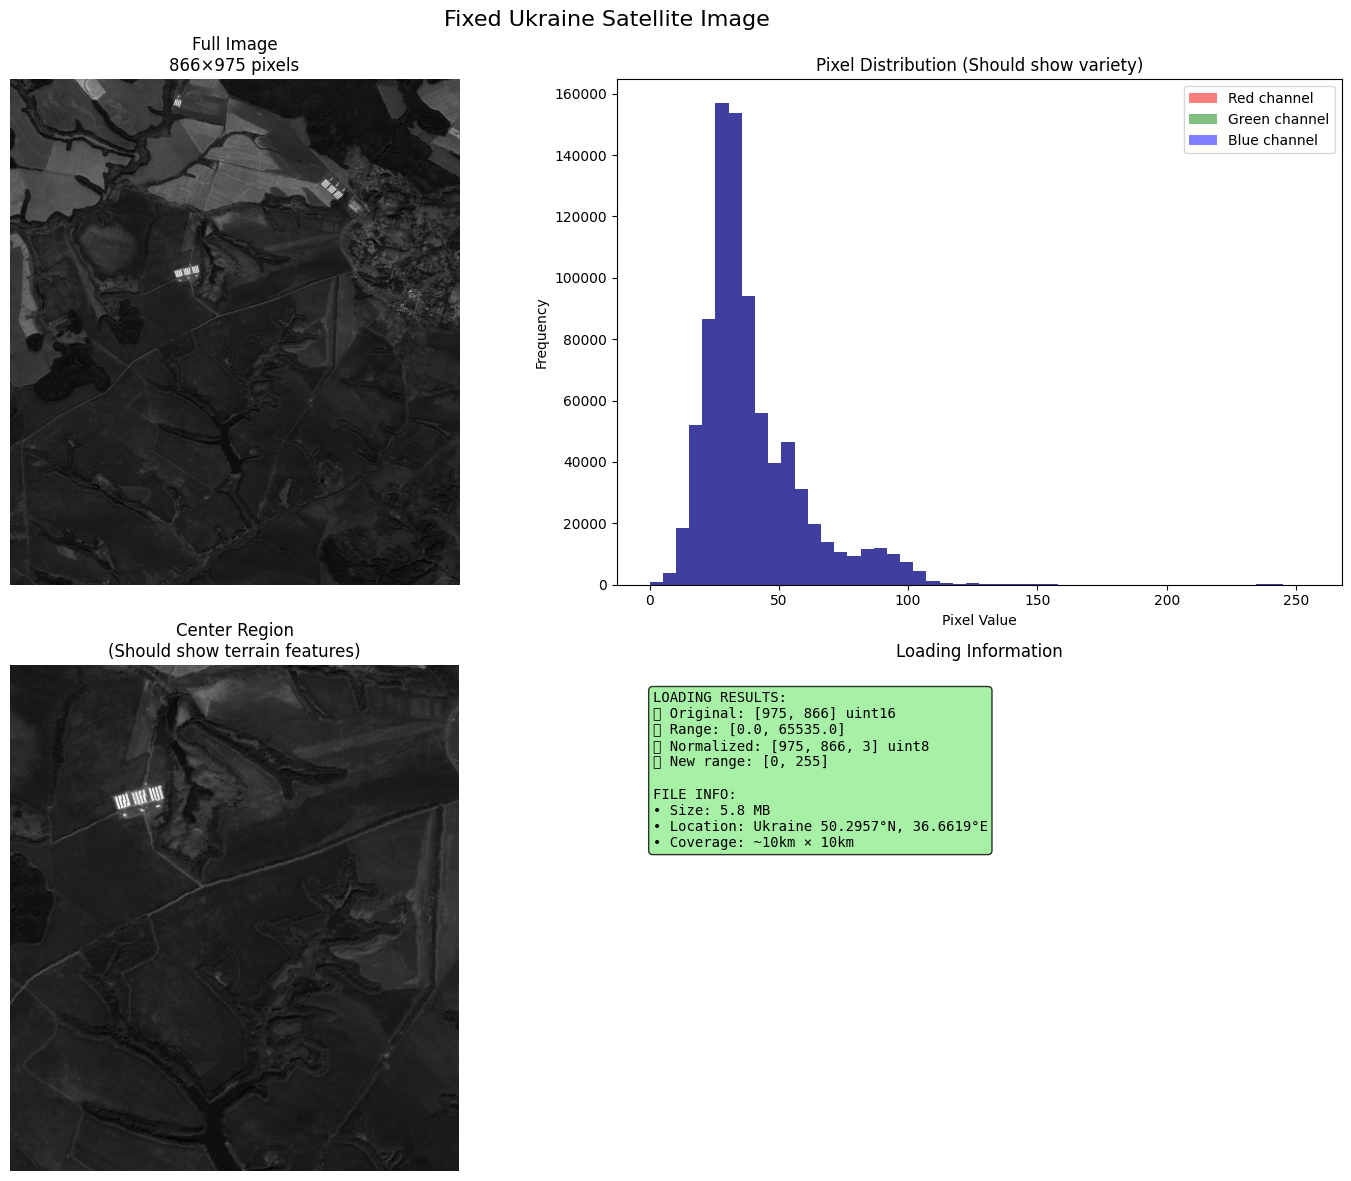


📐 CREATING REALISTIC DRONE PERSPECTIVES
   Viewing angle: ~60° from vertical (oblique)
   Number of crops: 30
   Progress: 1/30
   Progress: 11/30
   Progress: 21/30
✅ Created 30 realistic drone perspectives
   Output: realistic_drone_crops
   Metadata: realistic_drone_crops\realistic_drone_metadata.json
🖼️ Visualizing 12 realistic drone crops...


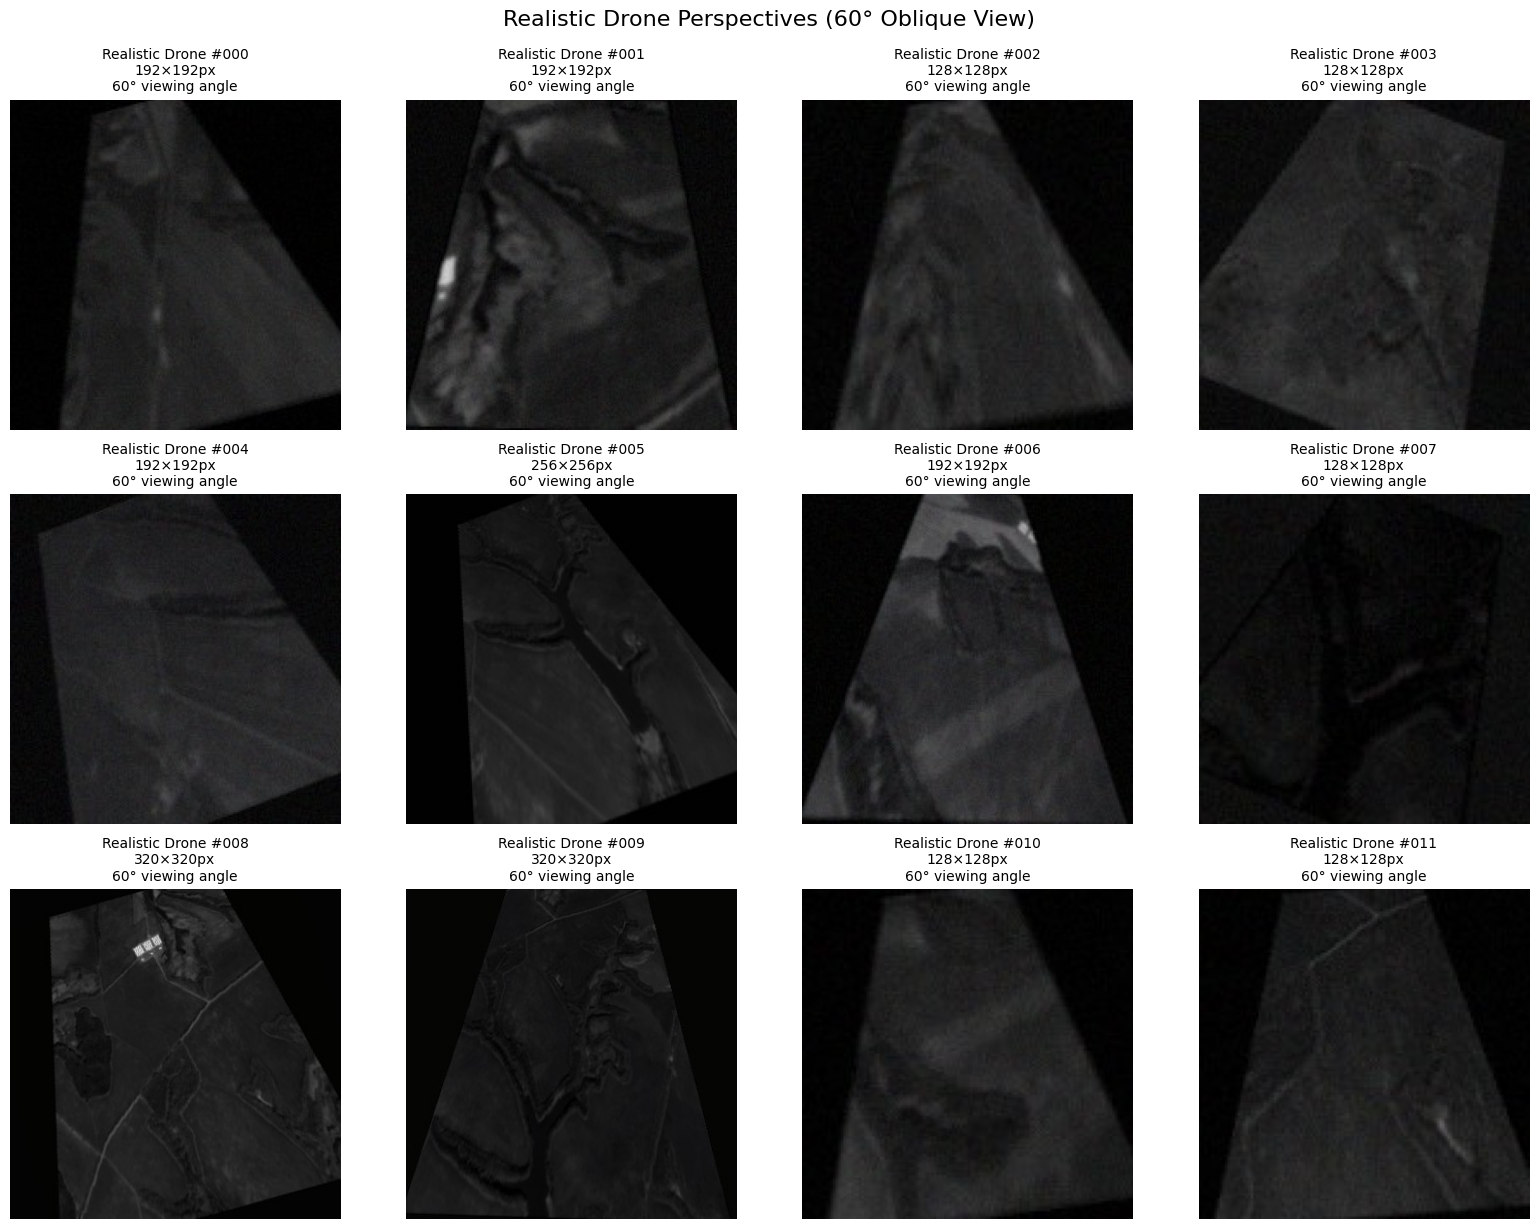


🎉 SUCCESS!
   ✅ Fixed TIF loading (no more white crops)
   ✅ Created 30 realistic drone perspectives
   ✅ Applied 60° viewing angle transformations
   ✅ Added atmospheric and camera effects
   📁 Output: realistic_drone_crops/


In [16]:
extractor, crops = fix_and_extract_realistic_drones()